In [6]:
import numpy as np
from tqdm import tqdm, trange
from brian2 import *
import matplotlib.pyplot as plt
from RE16_4ring_v52 import simulator
from util import *
from fit import *

FIG_PATH = 'figures/'
os.makedirs(FIG_PATH, exist_ok=True)


INFO       Cache size for target 'cython': 1194 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/pajucg/.cython/brian_extensions' directory. [brian2]


In [8]:
F = 1/3
_WEIGHT_MATRIX_SYMMETRY = np.array([
    [F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F],
    [F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, F, F, 0, 0, F, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, F, 0, 0, F, F, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F],
    [F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F]
], dtype=np.float32)

def process_data(data):
    '''
    input: data: (16, 16, T)
    output: out: (16, 16, T)
    '''
    W = _WEIGHT_MATRIX_SYMMETRY.astype(np.float32)
    C = np.zeros((16, 18), dtype=W.dtype)
    C[np.arange(8), np.arange(8)] = 1
    C[np.arange(8, 16), np.arange(10, 18)] = 1
    L = C @ W.T @ C.T   # (16, 16)
    R = C @ W   @ C.T  # (16, 16)
    out = np.einsum('ai, ijt, jb -> abt', L, data, R, optimize=True)  # (16, 16, T) 
    return out

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

def create_3d_animation(processed_data, vmin=0, vmax=300, frame_stride=200, frame_duration=0.1, transition_duration=200):
    """
    Create an interactive 3D surface plot animation with Plotly.
    
    Parameters:
    -----------
    processed_data : numpy.ndarray
        3D array of shape (height, width, time_frames) containing neural activity data
    vmin : float, optional
        Minimum value for colorbar range (default: 0)
    vmax : float, optional
        Maximum value for colorbar range (default: 300)
    frame_stride : int, optional
        Sample every nth frame to reduce file size (default: 200)
    frame_duration : float, optional
        Duration of each frame in milliseconds (default: 0.1)
    transition_duration : int, optional
        Transition duration between frames in milliseconds (default: 200)
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive 3D animation figure
    """
    
    # Create interactive 3D surface plot with Plotly
    fig = go.Figure()

    # Add initial frame
    fig.add_trace(go.Surface(
        z=processed_data[:, :, 0],
        colorscale='Blues',
        cmin=vmin,
        cmax=vmax,
        showscale=True,
        colorbar=dict(title="Firing Rate [Hz]")
    ))

    # Update layout for better visualization
    fig.update_layout(
        title='Neural Activity Evolution Over Time',
        scene=dict(
            xaxis_title='X Position',
            yaxis_title='Y Position', 
            zaxis_title='Firing Rate [Hz]',
            xaxis=dict(range=[0, 16]),
            yaxis=dict(range=[0, 16]),
            zaxis=dict(range=[vmin, vmax]),
            aspectmode='cube',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=600
    )

    # Create frames for animation
    frames = []
    slider_steps = []

    frame_names = []
    for i in range(0, processed_data.shape[2], frame_stride):
        frame_name = f'frame_{i}'
        frame_names.append(frame_name)
        frame = go.Frame(
            data=[go.Surface(
                z=processed_data[:, :, i],
                colorscale='Blues',
                cmin=vmin,
                cmax=vmax,
                showscale=True
            )],
            name=frame_name,
            layout=go.Layout(
                title=f'Neural Activity at t = {i/10000:.2f} s'
            )
        )
        frames.append(frame)
        slider_steps.append(
            dict(
                method='animate',
                label=f'{i/10000:.2f}s',
                args=[[frame_name], dict(mode='immediate', frame=dict(duration=frame_duration, redraw=True), transition=dict(duration=transition_duration))],
            )
        )

    # Add frames to the 3D figure
    fig.frames = frames
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=[None, {"frame": {"duration": frame_duration, "redraw": True},
                                    "fromcurrent": True, 
                                    "transition": {"duration": transition_duration},
                                    "mode": "immediate"}],
                        label="Play",
                        method="animate"
                    ),
                    dict(
                        args=[[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                        label="Pause",
                        method="animate"
                    )
                ]),
                pad={"r": 10, "t": 87},
                showactive=False,
                x=0.011,
                xanchor="right",
                y=0,
                yanchor="top"
            ),
        ],
        sliders=[dict(
            active=0,
            currentvalue={"prefix": "Time: "},
            steps=slider_steps
        )]
    )

    return fig



# Simulation parameters

In [10]:
parameters = {'w_EE': 0.72, 'w_EI': 0.14, 'w_IE': 0.74, 'w_II': 0.01, 'w_EP': 0.01, 'w_PE': 0.71, 'w_PP': 0.01, 'sigma': 0.0001}


In [11]:
parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, # 0.143
  "w_IE": 0.76, # 0.74
  "w_II": 0.01, # 0.01
  "w_PP": 0.01,
  "w_EP": 0.013, # 0.012
  "w_PE": 0.71, # .709
  "sigma": 0.001,
}

# events = [
#         {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
#         {'type': 'visual_cue_off', 'duration': 300*ms},
#         {'type': 'shift', 'direction': 'right', 'strength': conf['shifter_strength'], 'duration': 1100*ms},
#         {'type': 'shift', 'direction': 'up', 'strength': conf['shifter_strength'], 'duration': 1100*ms},
#         {'type': 'shift', 'direction': 'left', 'strength': conf['shifter_strength'], 'duration': 1100*ms},
#         {'type': 'shift', 'direction': 'down', 'strength': conf['shifter_strength'], 'duration': 1100*ms},
#     ]

events = [
        {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
        {'type': 'visual_cue_off', 'duration': 300*ms},
        {'type': 'shift', 'direction': 'right', 'strength': 0.018, 'duration': 2000*ms},
    ]



In [12]:
results = simulator(w_EE = parameters['w_EE'], # EB <-> EB
                    w_EI = parameters['w_EI'], # EPG -> R # 0.15
                    w_IE = parameters['w_IE'], # R -> EPG
                    w_II = parameters['w_II'], # R <-> R
                    w_PP = parameters['w_PP'], # PEN <-> PEN
                    w_EP = parameters['w_EP'], # EB -> PEN 
                    w_PE = parameters['w_PE'], # PEN -> EB
                    sigma = parameters['sigma'], # noise level
                    
                    events = events,
                    defaultclock_dt=0.1 # ms
                                    )
t, fr, fr_penx, fr_peny = results
print(len(t))

processed_data = process_data(fr)
# Plot the last frame
plt.figure(figsize=(8, 6))
last_frame = processed_data[:, :, -1]
im_last = plt.imshow(last_frame, cmap='Blues', aspect='auto', interpolation='none',
                     vmin=0, vmax=200)
plt.colorbar(im_last, label='Firing Rate [Hz]')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Final state (t = {(processed_data.shape[2]-1)/10000:.2f} s)')
plt.tight_layout()
plt.show()

03:45:46 : 0 min 1.5 sec -> simulation start


KeyboardInterrupt: 

# Activity Heatmap

In [ ]:
# Create and show the 3D animation
processed_data = process_data(fr)
fig = create_3d_animation(fr_penx)
fig.show()
fig = create_3d_animation(fr_peny)
fig.show()
fig = create_3d_animation(processed_data)
fig.show()


In [ ]:
from fit import bump_position
processed_data = process_data(fr)
bump_positions, fit_params = bump_position(processed_data)


Fitting 2D Gaussians:   0%|          | 13/2600 [00:00<00:21, 123.14it/s]

Fitting 2D Gaussians: 100%|██████████| 2600/2600 [00:18<00:00, 142.72it/s]


# Trajectory

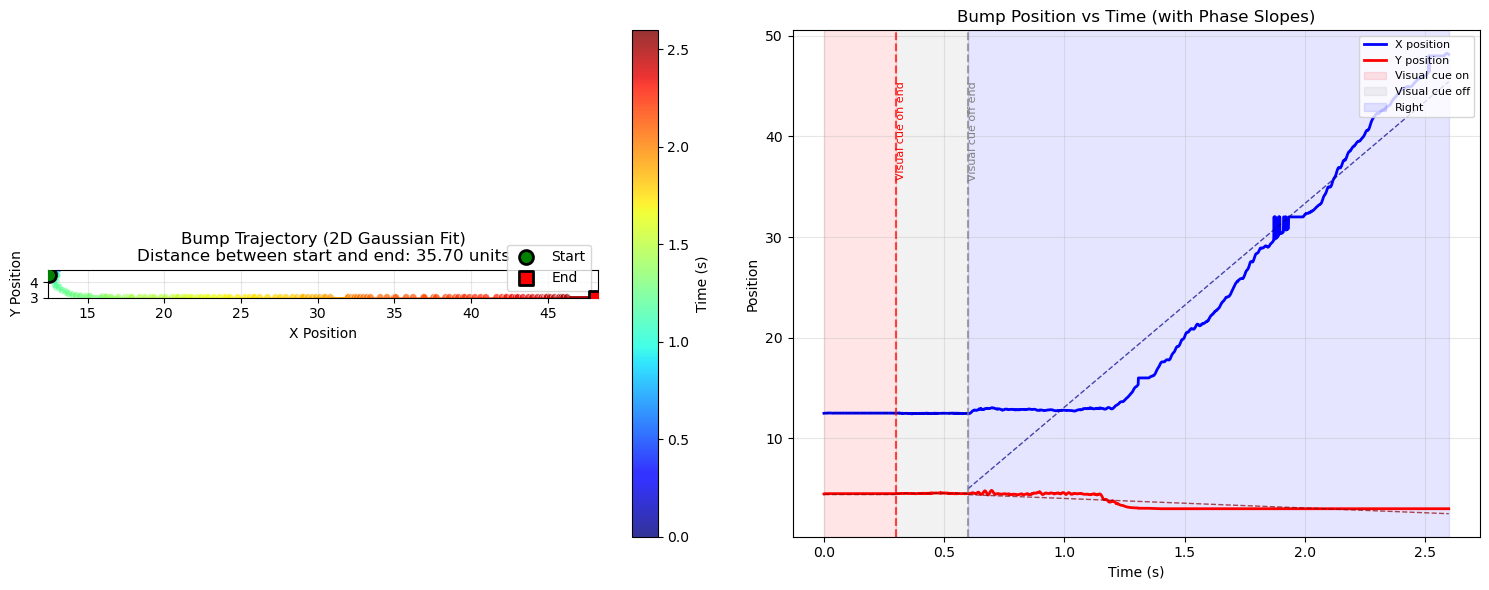


Trajectory Analysis:
Start point: (12.486, 4.470)
End point: (48.153, 3.000)
Total distance between start and end: 35.697 units

Phase-based velocity analysis:
Visual cue on  : vx=-0.011, vy= 0.010, speed= 0.003 rad/s
Visual cue off : vx= 0.000, vy= 0.016, speed= 0.003 rad/s
Right          : vx=20.237, vy=-0.948, speed= 3.978 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.003 rad/s
Right          : 0.6-2.6s (2.0s duration), speed=3.978 rad/s
Distance between start and end: 35.697 units


In [ ]:
from fit import analyze_trajectory
# Call the function with the required parameters
trajectory_results = analyze_trajectory(bump_positions, fit_params, processed_data, events)

In [ ]:
print(trajectory_results.keys())

dict_keys(['bump_positions', 'time_points', 'start_point', 'end_point', 'total_distance', 'phase_results', 'phases'])


In [ ]:
print(trajectory_results['bump_positions'])



[[12.4864269   4.47015093]
 [12.49384639  4.49194512]
 [12.49492086  4.49159915]
 ...
 [48.18504182  3.        ]
 [48.17889576  3.        ]
 [48.15349787  3.        ]]


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Extract bump positions
bump_positions = trajectory_results['bump_positions']
time_points = trajectory_results['time_points']

# Create the 3D plot
fig = go.Figure()

# Plot the trajectory with time as z-axis
fig.add_trace(go.Scatter3d(
    x=bump_positions[:, 0],
    y=bump_positions[:, 1],
    z=time_points,
    mode='lines',
    line=dict(color='blue', width=4),
    name='Trajectory',
    opacity=0.7
))

# Mark start and end points
fig.add_trace(go.Scatter3d(
    x=[bump_positions[0, 0]],
    y=[bump_positions[0, 1]],
    z=[time_points[0]],
    mode='markers',
    marker=dict(color='green', size=8, symbol='circle'),
    name='Start'
))

fig.add_trace(go.Scatter3d(
    x=[bump_positions[-1, 0]],
    y=[bump_positions[-1, 1]],
    z=[time_points[-1]],
    mode='markers',
    marker=dict(color='red', size=8, symbol='square'),
    name='End'
))

# Add some trajectory points for better visualization
n_points = 20
point_indices = np.linspace(0, len(bump_positions)-1, n_points, dtype=int)
fig.add_trace(go.Scatter3d(
    x=bump_positions[point_indices, 0],
    y=bump_positions[point_indices, 1],
    z=time_points[point_indices],
    mode='markers',
    marker=dict(
        color=time_points[point_indices],
        colorscale='viridis',
        size=4,
        opacity=0.6,
        colorbar=dict(title="Time")
    ),
    name='Trajectory Points'
))

fig.update_layout(
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Time'
    ),
    title='3D Bump Trajectory (X-Y-Time)',
    width=240,
    height=200
)

fig.show()


NameError: name 'trajectory_results' is not defined

In [ ]:
randn = np.random.randn(1)
print(np.abs(randn*10000//1))


[16670.]


Running 10 simulations using 10 processes


Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

05:31:49 : 0 min 1.6 sec -> simulation start
05:31:49 : 0 min 1.6 sec -> simulation start
05:31:49 : 0 min 1.6 sec -> simulation start
05:31:49 : 0 min 1.6 sec -> simulation start
05:31:49 : 0 min 1.6 sec -> simulation start
05:31:49 : 0 min 1.7 sec -> simulation start
05:31:49 : 0 min 1.7 sec -> simulation start
05:31:49 : 0 min 1.7 sec -> simulation start
05:31:49 : 0 min 1.7 sec -> simulation start
05:31:49 : 0 min 1.8 sec -> simulation start
05:35:59 : 4 min 11.5 sec -> simulation end


Fitting 2D Gaussians:   9%|▉         | 238/2600 [00:01<00:15, 152.00it/s]

05:36:01 : 4 min 13.8 sec -> simulation end


Fitting 2D Gaussians:  11%|█         | 286/2600 [00:01<00:15, 151.23it/s]

05:36:02 : 4 min 14.1 sec -> simulation end


Fitting 2D Gaussians:   1%|          | 26/2600 [00:00<00:30, 84.17it/s]] 

05:36:02 : 4 min 14.9 sec -> simulation end


Fitting 2D Gaussians:   1%|▏         | 35/2600 [00:00<00:40, 63.82it/s]

05:36:03 : 4 min 15.0 sec -> simulation end


Fitting 2D Gaussians:  15%|█▍        | 381/2600 [00:03<00:33, 66.61it/s]

05:36:03 : 4 min 15.2 sec -> simulation end


Fitting 2D Gaussians:   4%|▍         | 115/2600 [00:03<01:34, 26.37it/s]

05:36:05 : 4 min 17.5 sec -> simulation end


Fitting 2D Gaussians:  17%|█▋        | 443/2600 [00:05<01:26, 24.93it/s]

05:36:05 : 4 min 17.5 sec -> simulation end


Fitting 2D Gaussians:   3%|▎         | 88/2600 [00:04<02:21, 17.79it/s]]

05:36:08 : 4 min 20.7 sec -> simulation end


Fitting 2D Gaussians:   5%|▌         | 135/2600 [00:06<02:28, 16.57it/s]

05:36:10 : 4 min 22.0 sec -> simulation end

Fitting 2D Gaussians:   0%|          | 9/2600 [00:00<01:56, 22.18it/s]

Fitting 2D Gaussians:  86%|████████▌ | 2230/2600 [02:41<00:34, 10.82it/s]

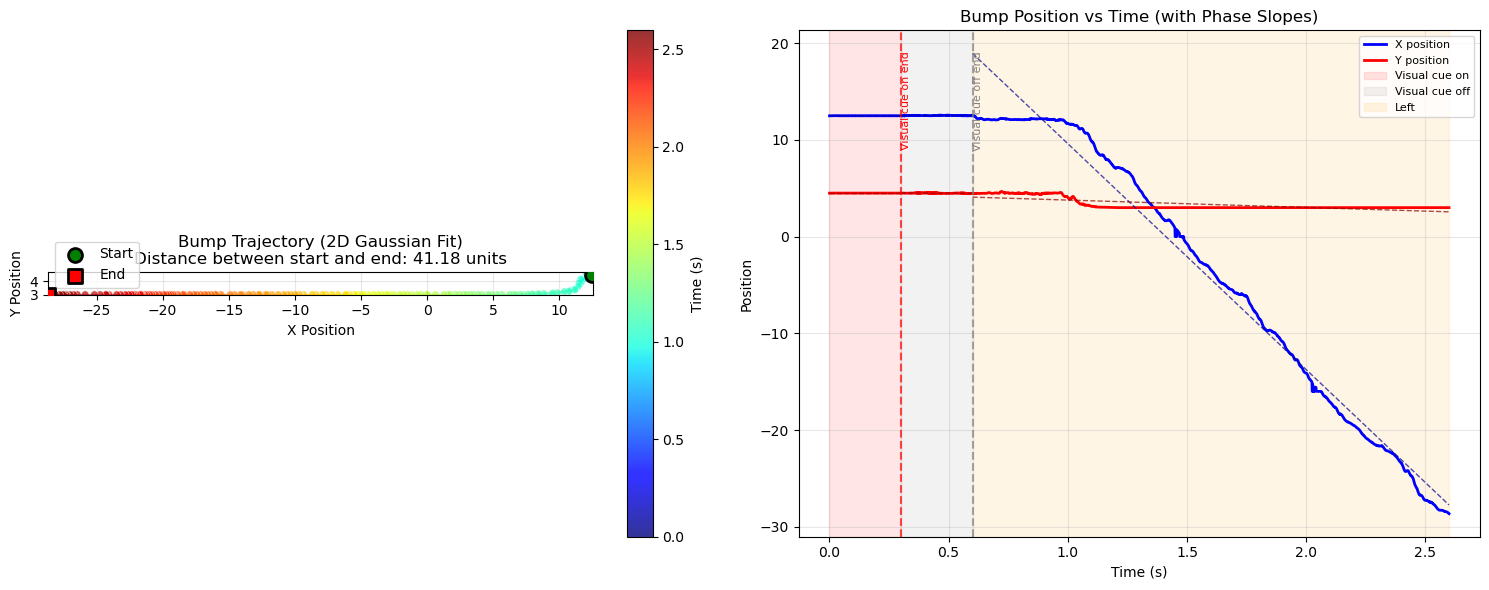


Trajectory Analysis:

Fitting 2D Gaussians:  84%|████████▍ | 2181/2600 [02:34<00:35, 11.94it/s]

Fitting 2D Gaussians:  89%|████████▉ | 2309/2600 [02:41<00:23, 12.57it/s]


Start point: (12.496, 4.496)
End point: (-28.656, 3.000)
Total distance between start and end: 41.179 units

Phase-based velocity analysis:


Fitting 2D Gaussians:  89%|████████▉ | 2317/2600 [02:40<00:21, 12.86it/s]

Fitting 2D Gaussians:  84%|████████▎ | 2171/2600 [02:37<00:32, 13.23it/s]

Fitting 2D Gaussians:  86%|████████▌ | 2224/2600 [02:37<00:31, 11.95it/s]

Visual cue on  : vx=-0.012, vy=-0.003, speed= 0.002 rad/s


Fitting 2D Gaussians:  85%|████████▍ | 2202/2600 [02:40<00:35, 11.32it/s]

Visual cue off : vx= 0.015, vy=-0.113, speed= 0.022 rad/s

Fitting 2D Gaussians:  84%|████████▍ | 2183/2600 [02:34<00:31, 13.45it/s]

Fitting 2D Gaussians:  86%|████████▌ | 2232/2600 [02:41<00:32, 11.26it/s]

Left           : vx=-23.366, vy=-0.761, speed= 4.590 rad/s


Fitting 2D Gaussians:  84%|████████▍ | 2190/2600 [02:40<00:35, 11.45it/s]


Phase summary:

Fitting 2D Gaussians:  89%|████████▉ | 2311/2600 [02:41<00:21, 13.64it/s]


Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s

Fitting 2D Gaussians:  86%|████████▌ | 2226/2600 [02:37<00:32, 11.67it/s]


Visual cue off : 0.3-0.6s (0.3s duration), speed=0.022 rad/s


Fitting 2D Gaussians:  89%|████████▉ | 2319/2600 [02:40<00:22, 12.27it/s]

Left           : 0.6-2.6s (2.0s duration), speed=4.590 rad/s

Fitting 2D Gaussians:  84%|████████▍ | 2185/2600 [02:34<00:29, 13.98it/s]

Fitting 2D Gaussians:  84%|████████▎ | 2173/2600 [02:37<00:34, 12.48it/s]

Distance between start and end: 41.179 units

Fitting 2D Gaussians:  85%|████████▍ | 2204/2600 [02:40<00:35, 11.23it/s]

Fitting 2D Gaussians:  95%|█████████▌| 2481/2600 [03:01<00:06, 18.02it/s]

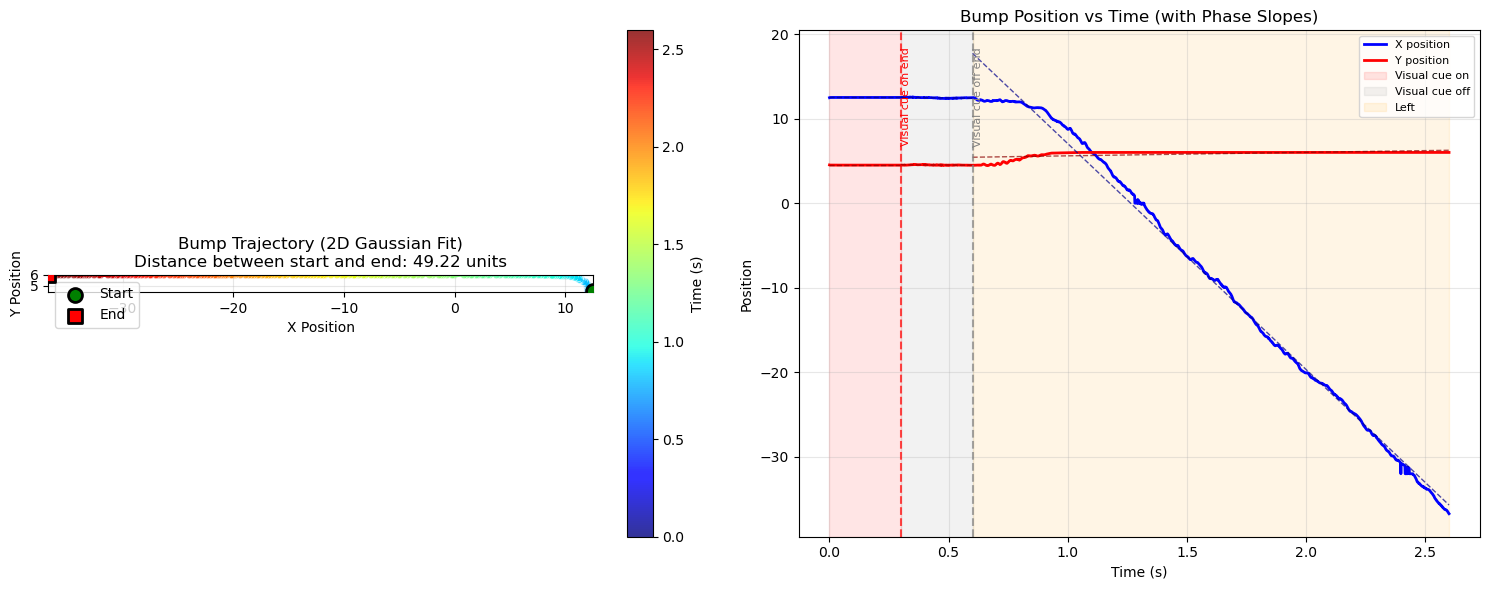

Fitting 2D Gaussians:  92%|█████████▏| 2391/2600 [02:54<00:14, 14.44it/s]


Trajectory Analysis:

Fitting 2D Gaussians:  97%|█████████▋| 2531/2600 [02:59<00:04, 13.81it/s]

Fitting 2D Gaussians: 100%|█████████▉| 2599/2600 [03:02<00:00, 13.77it/s]

Fitting 2D Gaussians:  95%|█████████▌| 2479/2600 [02:56<00:09, 12.58it/s]

Fitting 2D Gaussians:  96%|█████████▌| 2497/2600 [03:02<00:07, 13.01it/s]

Start point: (12.474, 4.521)
End point: (-36.725, 6.000)

Fitting 2D Gaussians: 100%|██████████| 2600/2600 [03:02<00:00, 14.27it/s]

Total distance between start and end: 49.221 units


Fitting 2D Gaussians:  97%|█████████▋| 2533/2600 [02:59<00:05, 12.83it/s]


Phase-based velocity analysis:


Fitting 2D Gaussians:  96%|█████████▌| 2483/2600 [03:01<00:07, 16.18it/s]

Fitting 2D Gaussians:  92%|█████████▏| 2393/2600 [02:55<00:14, 14.59it/s]


Visual cue on  : vx= 0.005, vy=-0.009, speed= 0.002 rad/s

Fitting 2D Gaussians:  95%|█████████▍| 2467/2600 [02:59<00:11, 12.02it/s]


Visual cue off : vx=-0.328, vy=-0.162, speed= 0.072 rad/s
Left           : vx=-26.719, vy= 0.412, speed= 5.247 rad/s


Fitting 2D Gaussians:  96%|█████████▌| 2499/2600 [03:02<00:07, 14.33it/s]


Phase summary:


Fitting 2D Gaussians:  95%|█████████▌| 2482/2600 [02:56<00:08, 13.98it/s]

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s


Fitting 2D Gaussians:  98%|█████████▊| 2535/2600 [02:59<00:04, 14.29it/s]

Visual cue off : 0.3-0.6s (0.3s duration), speed=0.072 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=5.247 rad/s

Fitting 2D Gaussians:  96%|█████████▌| 2485/2600 [03:01<00:07, 15.01it/s]

Fitting 2D Gaussians:  92%|█████████▏| 2395/2600 [02:55<00:14, 13.68it/s]

Distance between start and end: 49.221 units

Fitting 2D Gaussians:  95%|█████████▍| 2469/2600 [02:59<00:11, 11.41it/s]

Fitting 2D Gaussians:  96%|█████████▌| 2485/2600 [03:00<00:07, 15.05it/s]

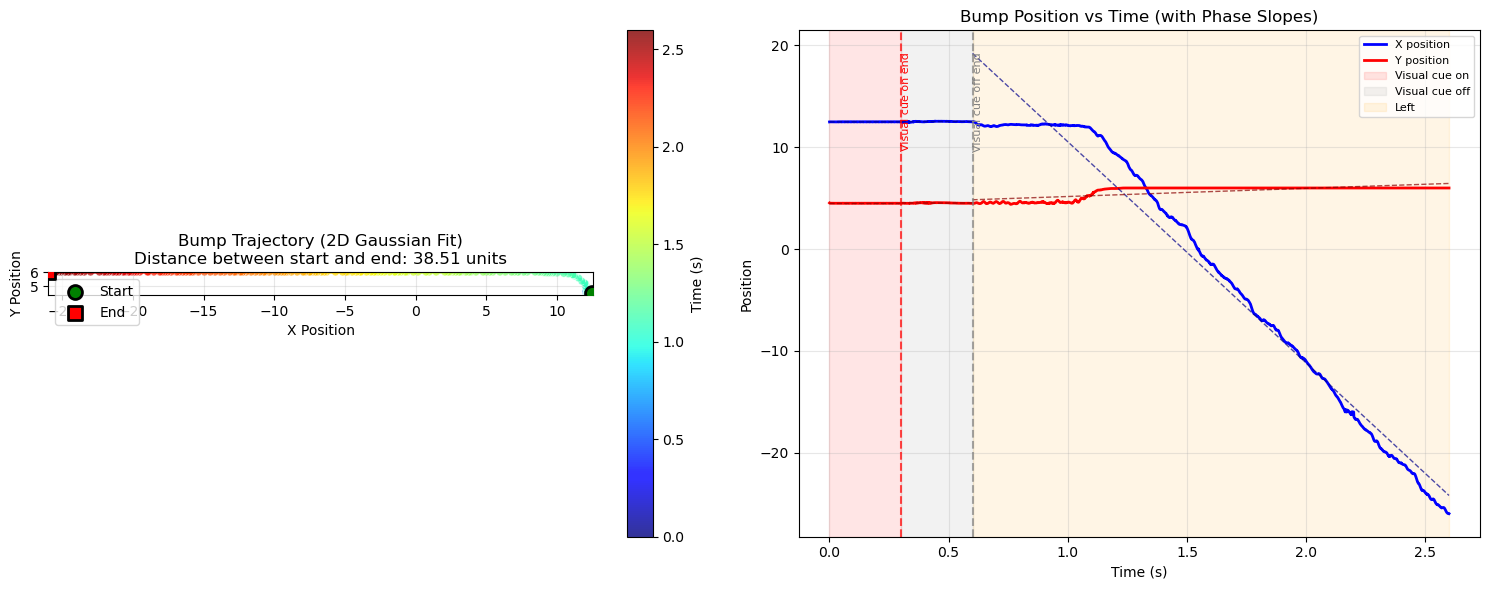

Fitting 2D Gaussians:  98%|█████████▊| 2560/2600 [03:04<00:02, 16.32it/s]


Trajectory Analysis:

Fitting 2D Gaussians:  97%|█████████▋| 2518/2600 [03:03<00:05, 15.63it/s]

Fitting 2D Gaussians:  96%|█████████▌| 2498/2600 [02:57<00:08, 12.17it/s]

Fitting 2D Gaussians:  98%|█████████▊| 2551/2600 [03:00<00:03, 14.05it/s]

Start point: (12.492, 4.528)

Fitting 2D Gaussians:  96%|█████████▌| 2501/2600 [03:02<00:07, 14.03it/s]


End point: (-25.988, 6.000)

Fitting 2D Gaussians:  93%|█████████▎| 2413/2600 [02:56<00:11, 16.32it/s]


Total distance between start and end: 38.508 units


Fitting 2D Gaussians:  99%|█████████▊| 2562/2600 [03:04<00:02, 16.59it/s]


Phase-based velocity analysis:

Fitting 2D Gaussians:  97%|█████████▋| 2521/2600 [03:03<00:04, 17.86it/s]


Visual cue on  : vx= 0.010, vy=-0.008, speed= 0.003 rad/s

Fitting 2D Gaussians:  96%|█████████▌| 2488/2600 [03:00<00:06, 16.02it/s]

Fitting 2D Gaussians:  98%|█████████▊| 2553/2600 [03:00<00:03, 13.91it/s]

Visual cue off : vx= 0.110, vy=-0.023, speed= 0.022 rad/s
Left           : vx=-21.729, vy= 0.803, speed= 4.269 rad/s


Fitting 2D Gaussians:  93%|█████████▎| 2415/2600 [02:56<00:11, 15.91it/s]


Phase summary:

Fitting 2D Gaussians:  96%|█████████▌| 2500/2600 [02:57<00:07, 12.60it/s]

Fitting 2D Gaussians:  96%|█████████▋| 2503/2600 [03:03<00:07, 13.53it/s]

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s


Fitting 2D Gaussians:  99%|█████████▊| 2564/2600 [03:04<00:02, 16.66it/s]

Visual cue off : 0.3-0.6s (0.3s duration), speed=0.022 rad/s


Fitting 2D Gaussians:  93%|█████████▎| 2417/2600 [02:56<00:10, 16.85it/s]

Left           : 0.6-2.6s (2.0s duration), speed=4.269 rad/s

Fitting 2D Gaussians:  96%|█████████▌| 2490/2600 [03:00<00:06, 16.82it/s]

Fitting 2D Gaussians:  98%|█████████▊| 2555/2600 [03:01<00:02, 15.26it/s]

Distance between start and end: 38.508 units


Fitting 2D Gaussians:  98%|█████████▊| 2554/2600 [03:06<00:02, 16.27it/s]

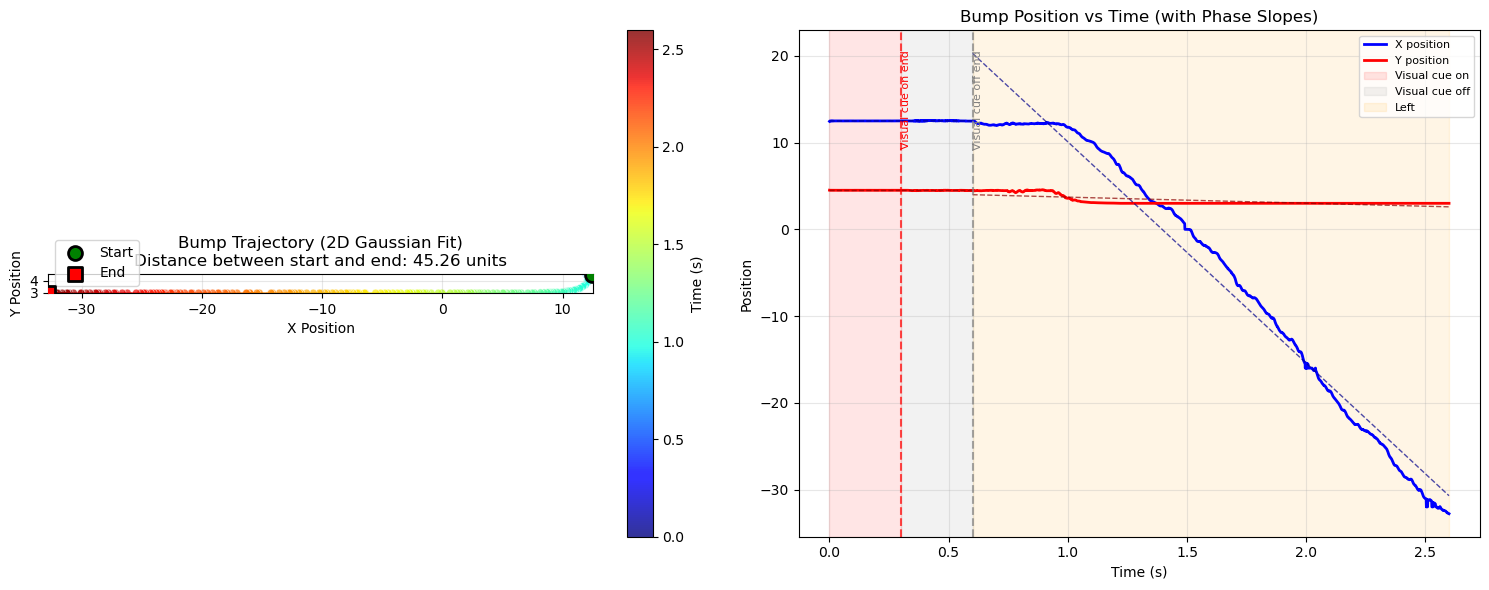

Fitting 2D Gaussians:  95%|█████████▍| 2468/2600 [02:59<00:07, 16.73it/s]


Trajectory Analysis:


Fitting 2D Gaussians:  99%|█████████▉| 2575/2600 [03:06<00:01, 18.98it/s]

Start point: (12.451, 4.513)


Fitting 2D Gaussians:  98%|█████████▊| 2558/2600 [03:00<00:01, 23.15it/s]

End point: (-32.787, 3.000)
Total distance between start and end: 45.264 units

Phase-based velocity analysis:
Visual cue on  : vx= 0.013, vy=-0.010, speed= 0.003 rad/s
Visual cue off : vx=-0.018, vy=-0.000, speed= 0.004 rad/s


Fitting 2D Gaussians:  98%|█████████▊| 2556/2600 [03:06<00:02, 15.97it/s]

Left           : vx=-25.515, vy=-0.699, speed= 5.012 rad/s

Fitting 2D Gaussians:  98%|█████████▊| 2549/2600 [03:03<00:03, 16.56it/s]

Fitting 2D Gaussians:  95%|█████████▌| 2471/2600 [02:59<00:07, 17.93it/s]


Phase summary:

Fitting 2D Gaussians:  99%|█████████▉| 2578/2600 [03:06<00:01, 21.09it/s]

Fitting 2D Gaussians:  99%|█████████▊| 2562/2600 [03:00<00:01, 26.13it/s]

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.004 rad/s


Fitting 2D Gaussians:  98%|█████████▊| 2558/2600 [03:06<00:02, 16.63it/s]

Left           : 0.6-2.6s (2.0s duration), speed=5.012 rad/s
Distance between start and end: 45.264 units

Fitting 2D Gaussians:  98%|█████████▊| 2551/2600 [03:04<00:02, 16.58it/s]

Fitting 2D Gaussians:  99%|█████████▊| 2562/2600 [03:04<00:01, 19.83it/s]

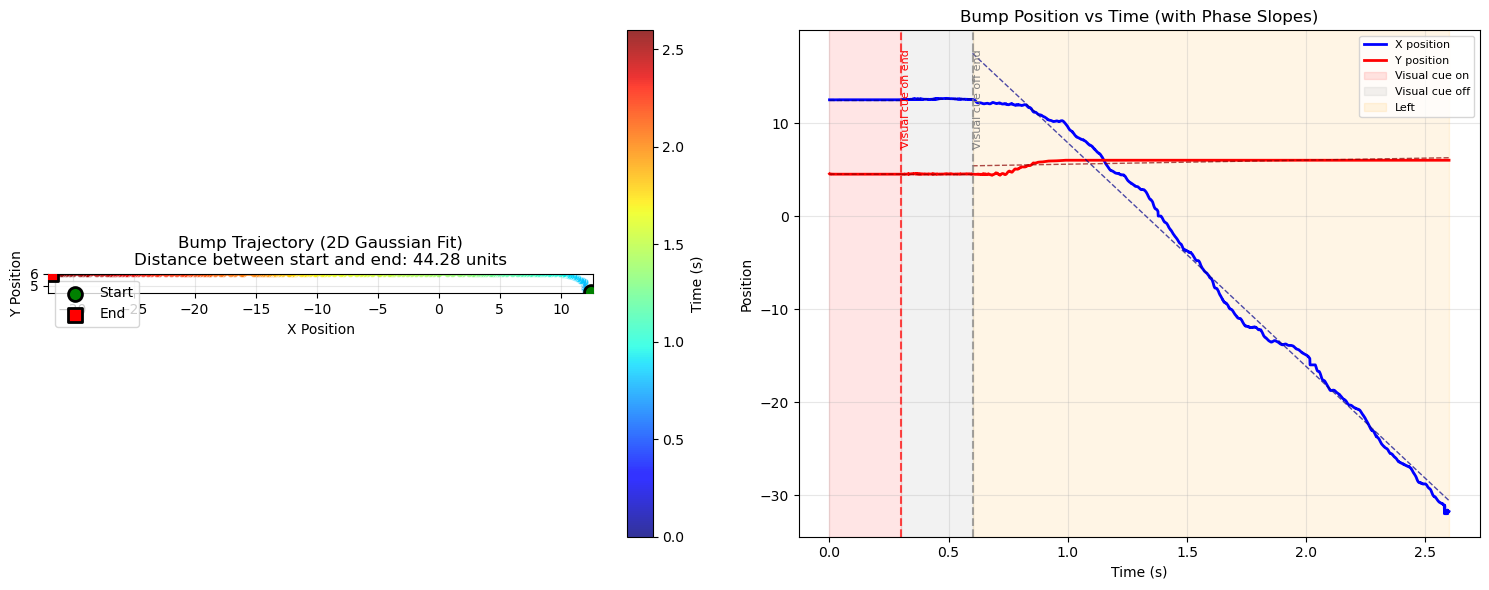


Trajectory Analysis:

Fitting 2D Gaussians:  96%|█████████▌| 2485/2600 [03:00<00:05, 21.56it/s]


Start point: (12.498, 4.538)
End point: (-31.760, 6.000)

Fitting 2D Gaussians: 100%|█████████▉| 2593/2600 [03:07<00:00, 22.32it/s]


Total distance between start and end: 44.282 units

Fitting 2D Gaussians:  99%|█████████▉| 2571/2600 [03:06<00:01, 21.30it/s]



Phase-based velocity analysis:
Visual cue on  : vx= 0.006, vy=-0.011, speed= 0.003 rad/s
Visual cue off : vx= 0.132, vy= 0.007, speed= 0.026 rad/s

Fitting 2D Gaussians:  99%|█████████▊| 2565/2600 [03:04<00:01, 21.03it/s]


Left           : vx=-24.053, vy= 0.435, speed= 4.723 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.026 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=4.723 rad/s


Fitting 2D Gaussians:  99%|█████████▉| 2580/2600 [03:01<00:00, 23.98it/s]

Distance between start and end: 44.282 units

Fitting 2D Gaussians:  99%|█████████▉| 2574/2600 [03:07<00:01, 21.73it/s]

Fitting 2D Gaussians:  97%|█████████▋| 2513/2600 [03:01<00:03, 24.13it/s]

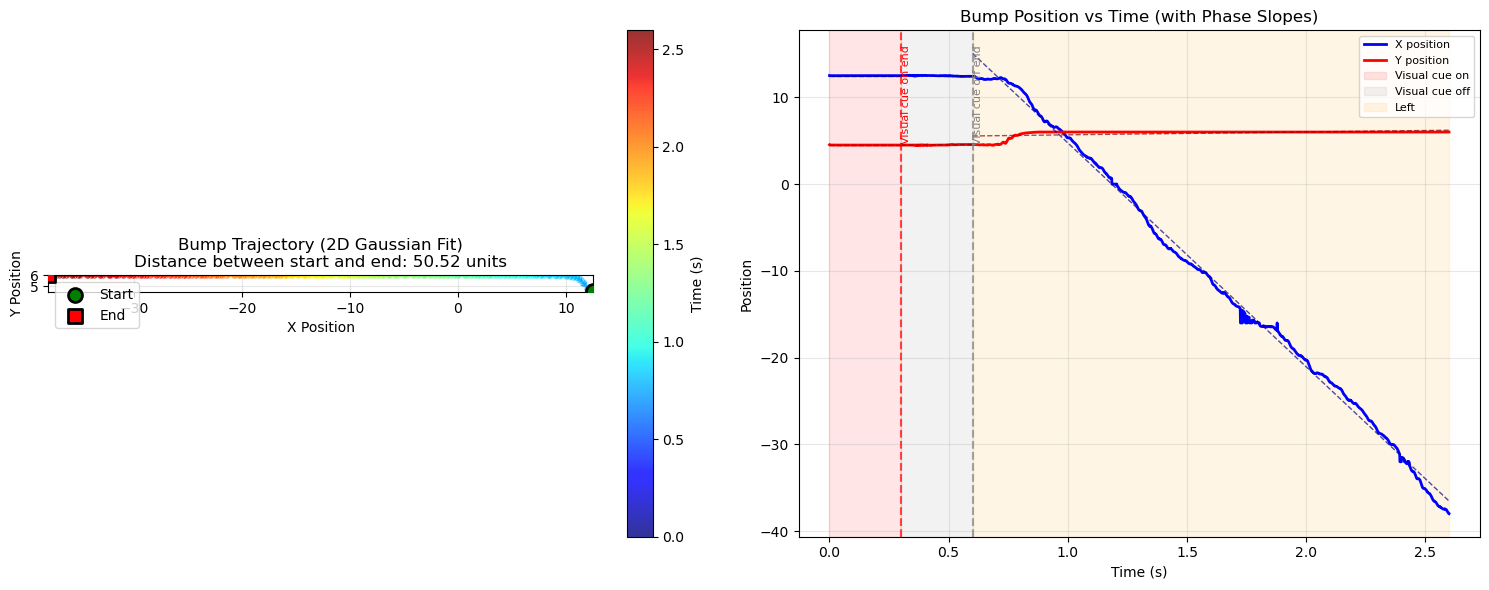


Trajectory Analysis:
Start point: (12.512, 4.532)
End point: (-37.989, 6.000)
Total distance between start and end: 50.522 units

Phase-based velocity analysis:
Visual cue on  : vx=-0.000, vy=-0.009, speed= 0.002 rad/s
Visual cue off : vx=-0.373, vy= 0.281, speed= 0.092 rad/s
Left           : vx=-25.809, vy= 0.331, speed= 5.068 rad/s

Fitting 2D Gaussians: 100%|█████████▉| 2592/2600 [03:06<00:00, 21.24it/s]



Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.092 rad/s


Fitting 2D Gaussians:  97%|█████████▋| 2516/2600 [03:01<00:03, 23.36it/s]

Left           : 0.6-2.6s (2.0s duration), speed=5.068 rad/s
Distance between start and end: 50.522 units


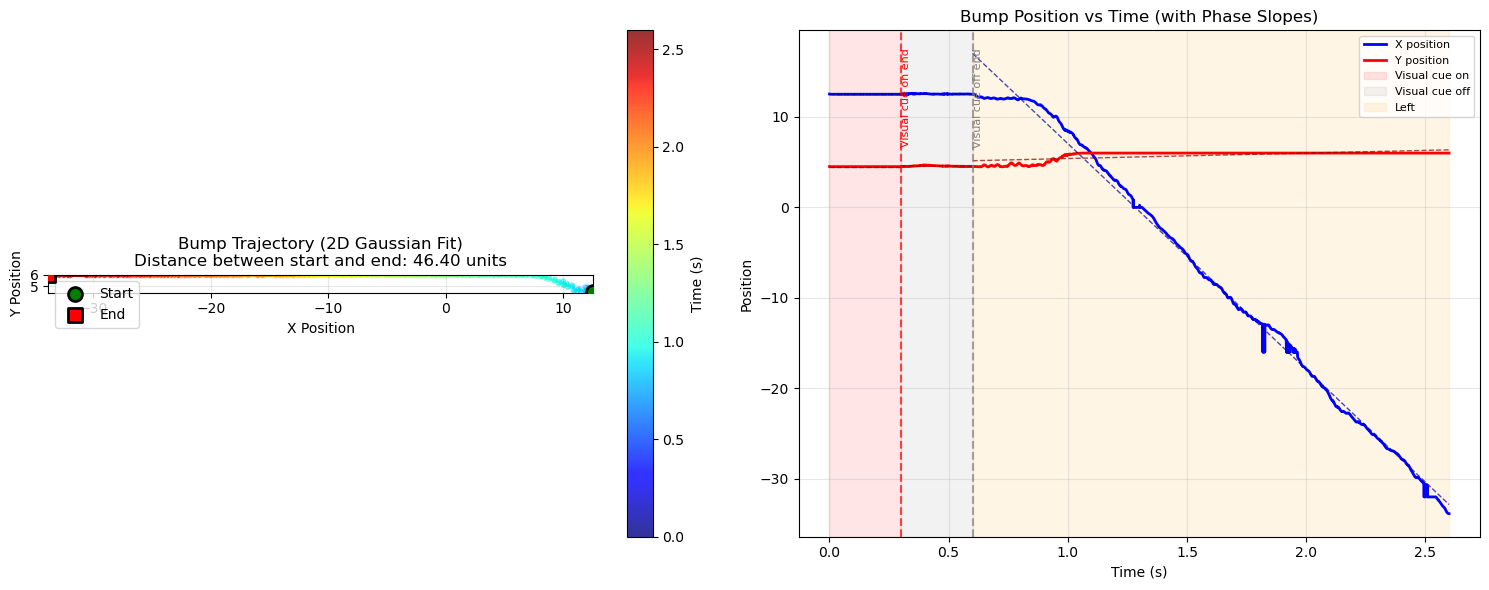


Trajectory Analysis:
Start point: (12.522, 4.517)
End point: (-33.855, 6.000)
Total distance between start and end: 46.401 units

Phase-based velocity analysis:

Fitting 2D Gaussians: 100%|█████████▉| 2595/2600 [03:06<00:00, 21.57it/s]

Fitting 2D Gaussians:  97%|█████████▋| 2519/2600 [03:01<00:03, 24.64it/s]

Visual cue on  : vx=-0.006, vy=-0.008, speed= 0.002 rad/s
Visual cue off : vx=-0.107, vy=-0.121, speed= 0.032 rad/s
Left           : vx=-24.942, vy= 0.601, speed= 4.899 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.032 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=4.899 rad/s
Distance between start and end: 46.401 units


Fitting 2D Gaussians: 100%|██████████| 2600/2600 [03:06<00:00, 13.95it/s]


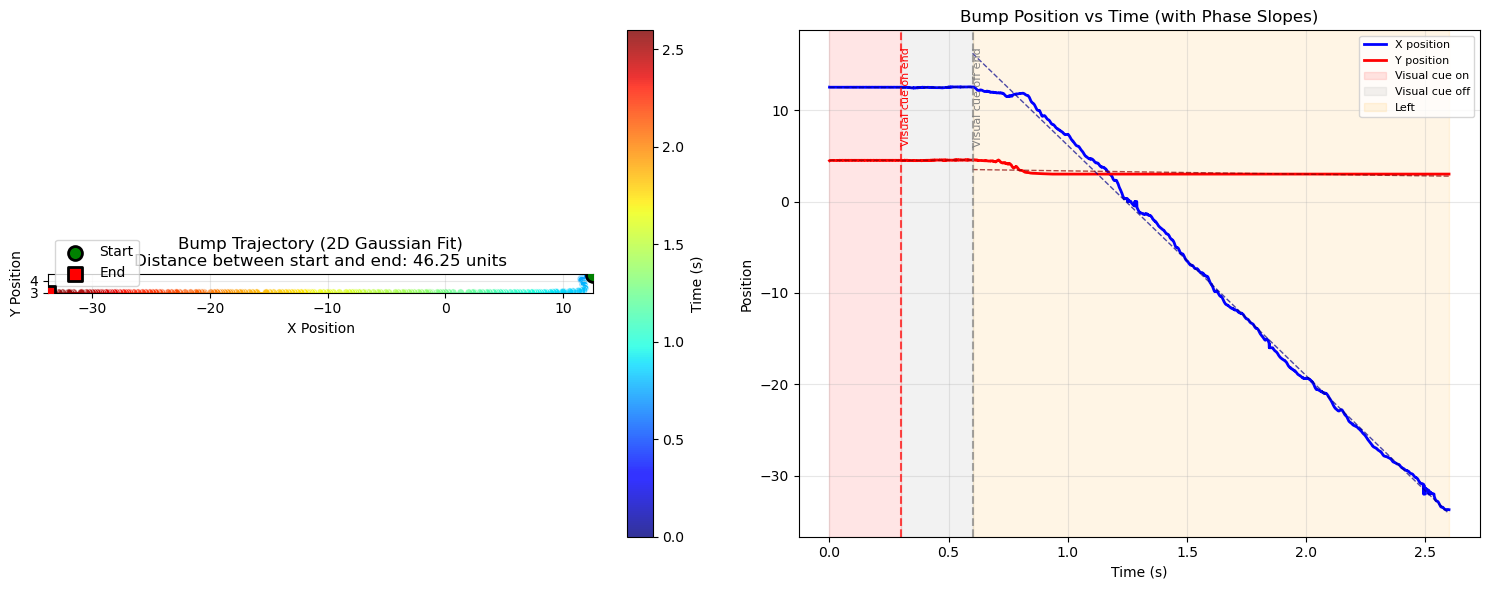


Trajectory Analysis:
Start point: (12.509, 4.465)
End point: (-33.713, 3.000)
Total distance between start and end: 46.245 units


Fitting 2D Gaussians:  97%|█████████▋| 2527/2600 [03:02<00:02, 31.39it/s]


Phase-based velocity analysis:
Visual cue on  : vx=-0.002, vy= 0.023, speed= 0.004 rad/s
Visual cue off : vx= 0.269, vy= 0.236, speed= 0.070 rad/s
Left           : vx=-25.193, vy=-0.362, speed= 4.947 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.004 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.070 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=4.947 rad/s
Distance between start and end: 46.245 units


Fitting 2D Gaussians:  98%|█████████▊| 2548/2600 [03:02<00:00, 54.83it/s]

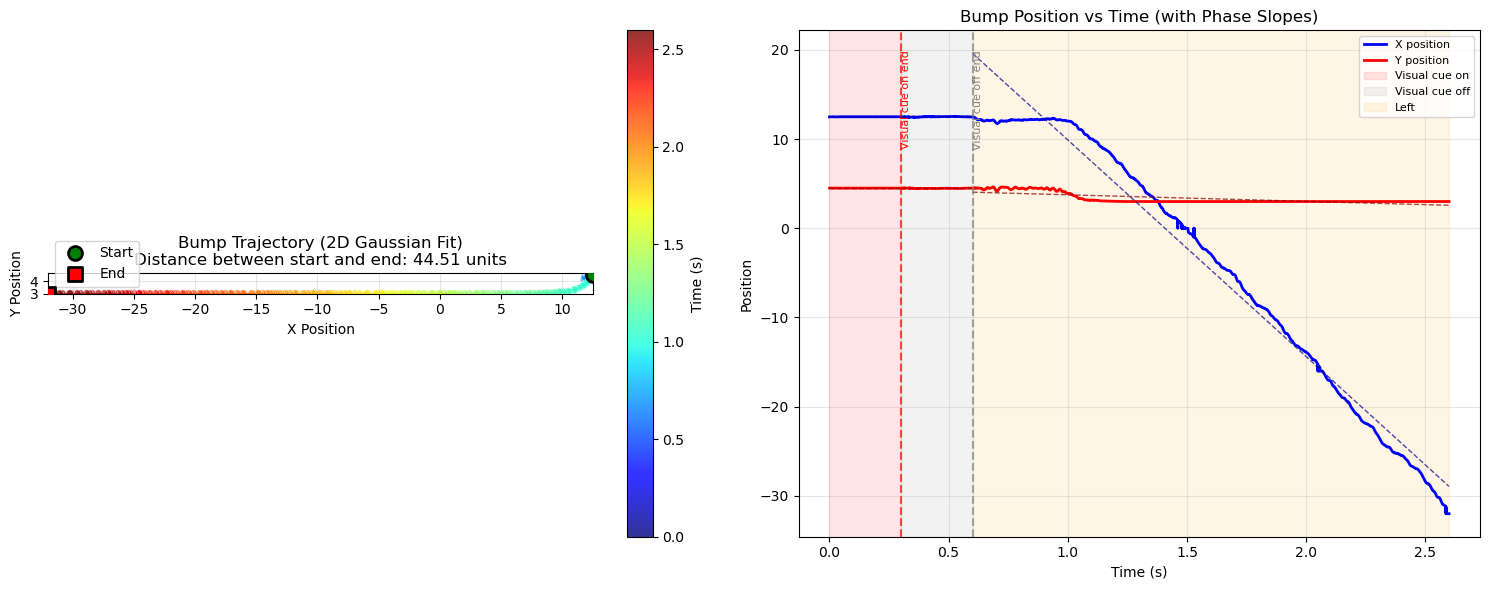


Trajectory Analysis:
Start point: (12.489, 4.506)
End point: (-32.000, 3.000)
Total distance between start and end: 44.514 units

Phase-based velocity analysis:
Visual cue on  : vx= 0.011, vy=-0.008, speed= 0.003 rad/s
Visual cue off : vx= 0.141, vy=-0.008, speed= 0.028 rad/s
Left           : vx=-24.289, vy=-0.735, speed= 4.771 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.028 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=4.771 rad/s
Distance between start and end: 44.514 units


Fitting 2D Gaussians: 100%|██████████| 2600/2600 [03:02<00:00, 14.23it/s] 


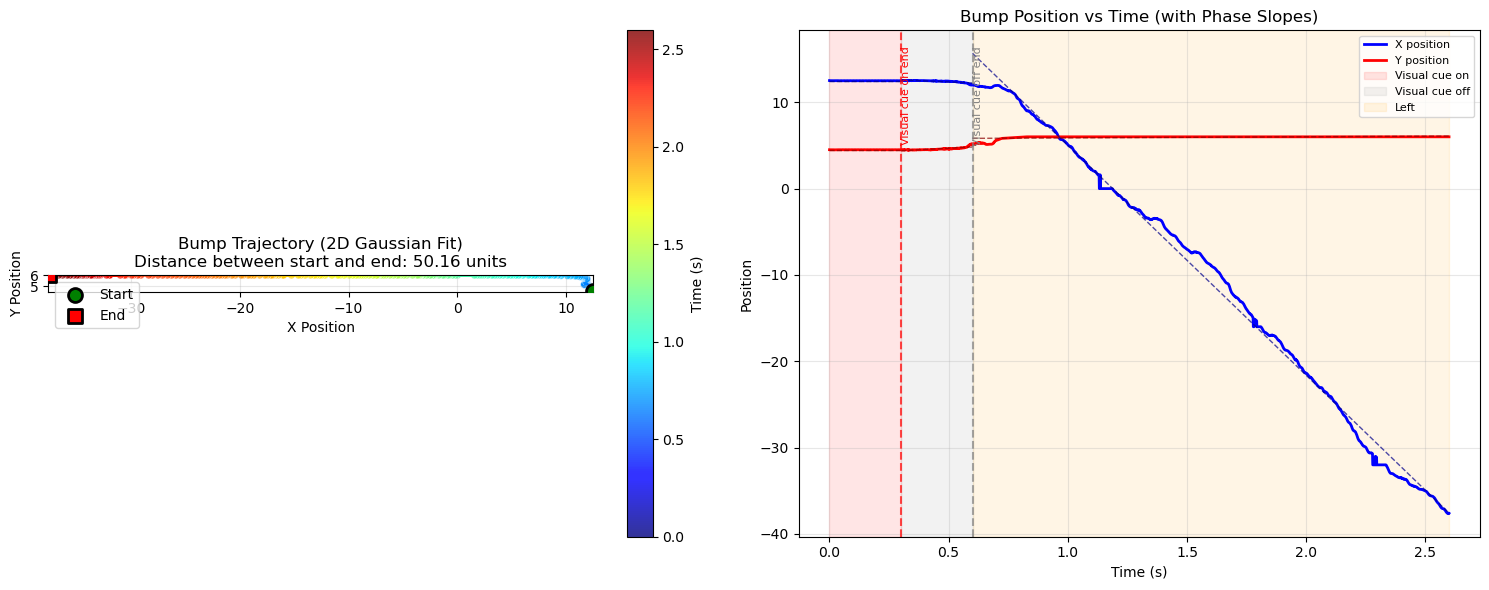


Trajectory Analysis:
Start point: (12.516, 4.505)
End point: (-37.619, 6.000)
Total distance between start and end: 50.157 units

Phase-based velocity analysis:
Visual cue on  : vx=-0.009, vy= 0.006, speed= 0.002 rad/s
Visual cue off : vx=-1.197, vy= 1.462, speed= 0.371 rad/s
Left           : vx=-26.642, vy= 0.131, speed= 5.231 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.371 rad/s
Left           : 0.6-2.6s (2.0s duration), speed=5.231 rad/s
Distance between start and end: 50.157 units


Running simulations: 100%|██████████| 10/10 [07:25<00:00, 44.58s/it]


In [25]:
from tqdm import tqdm, trange
from multiprocessing import Pool
import multiprocessing as mp
import random

parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, # 0.143
  "w_IE": 0.76, # 0.74
  "w_II": 0.01, # 0.01
  "w_PP": 0.01,
  "w_EP": 0.013, # 0.012
  "w_PE": 0.71, # .709
  "sigma": 0.001,
}

events = [
        {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
        {'type': 'visual_cue_off', 'duration': 300*ms},
        {'type': 'shift', 'direction': 'left', 'strength': 0.018, 'duration': 2000*ms},
    ]


def run_single_simulation(seed):
    """
    Run a single simulation with a given random seed
    
    Args:
        seed (int): Random seed for the simulation
    
    Returns:
        tuple: (speed, bump_positions) from the simulation
    """
    t, fr, fr_penx, fr_peny = simulator(w_EE = parameters['w_EE'], # EB <-> EB
                    w_EI = parameters['w_EI'], # EPG -> R # 0.15
                    w_IE = parameters['w_IE'], # R -> EPG
                    w_II = parameters['w_II'], # R <-> R
                    w_PP = parameters['w_PP'], # PEN <-> PEN
                    w_EP = parameters['w_EP'], # EB -> PEN 
                    w_PE = parameters['w_PE'], # PEN -> EB
                    sigma = parameters['sigma'], # noise level
                    
                    events = events,
                    defaultclock_dt=0.1,
                    seed=seed)

    processed_data = process_data(fr)
    bp, fit_params = bump_position(processed_data)
    trajectory_results = analyze_trajectory(bp, fit_params, processed_data, events)
    direction = events[2]['direction'].capitalize() 
    speed = trajectory_results['phase_results'][direction]['speed']
    bump_pos = trajectory_results['bump_positions']
    return speed, bump_pos


def run_multiple_simulations(parameters, events, num_simulations=10, n_processes=None):
    """
    Run multiple simulations with different random seeds and collect results using parallel computation
    
    Args:
        parameters (dict): Parameters for the simulation
        events (list): List of events for the simulation
        num_simulations (int): Number of simulations to run
        n_processes (int): Number of processes to use. If None, uses all available CPUs
    
    Returns:
        tuple: (speeds, bump_positions) lists from all simulations
    """ 
    if n_processes is None:
        n_processes = mp.cpu_count()
    
    print(f"Running {num_simulations} simulations using {n_processes} processes")
    
    # Create list of seeds for each simulation
    seeds = list(range(num_simulations))
    
    # Run simulations in parallel
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(run_single_simulation, seeds),
            total=num_simulations,
            desc="Running simulations"
        ))
    
    # Separate speeds and bump_positions
    speeds = [result[0] for result in results]
    bump_positions = [result[1] for result in results]
    
    return speeds, bump_positions

speeds, bump_positions = run_multiple_simulations(parameters, events, num_simulations=10, n_processes=10)

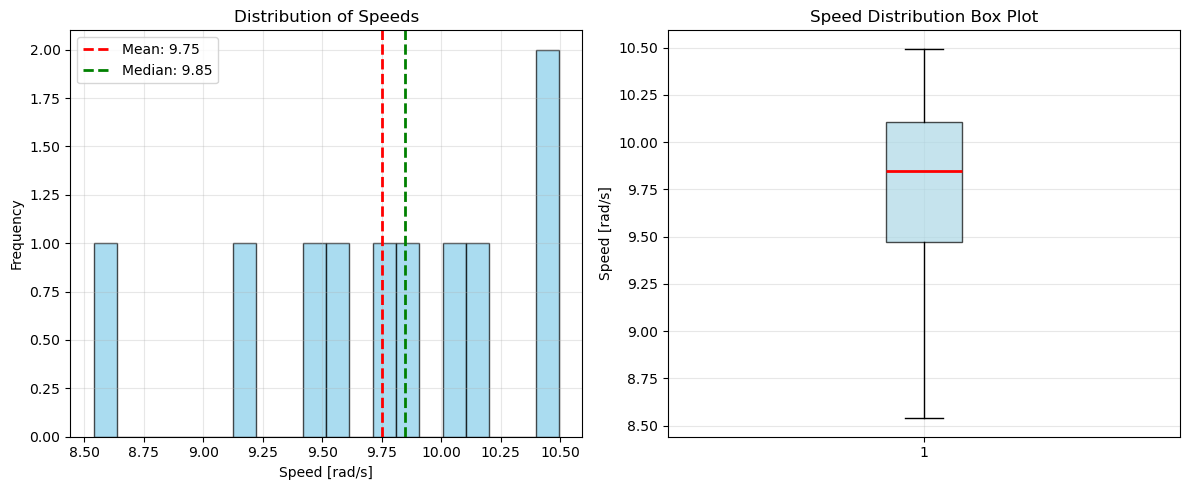

Speed Statistics:
Mean: 9.75 [rad/s]
Standard Deviation: 0.57 [rad/s]
Median: 9.85 [rad/s]
Min: 8.54 [rad/s]
Max: 10.49 [rad/s]



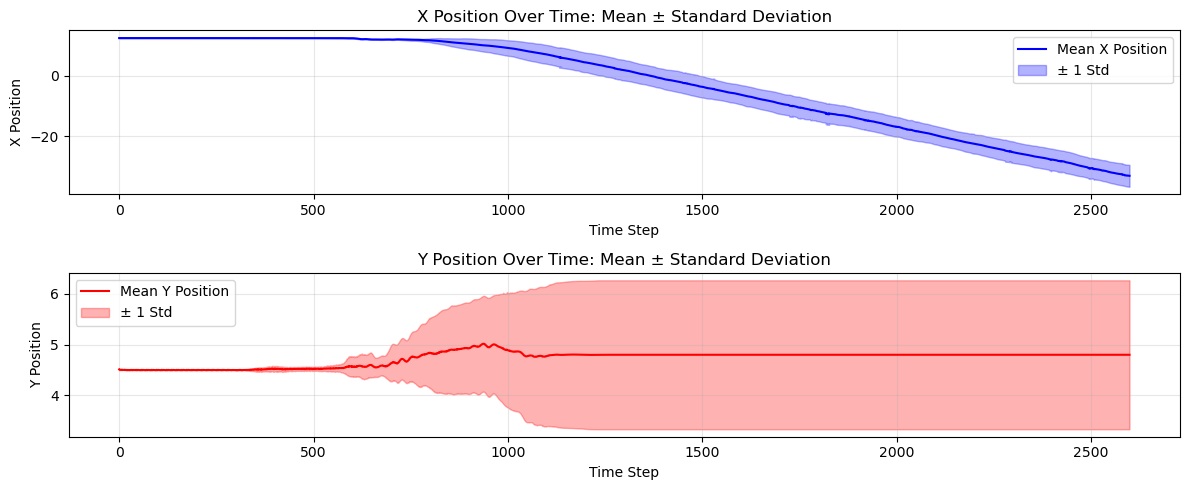

In [26]:
# Calculate statistics for speeds
speeds_array = np.array(speeds)
speed_mean = np.mean(speeds_array)
speed_std = np.std(speeds_array)
speed_median = np.median(speeds_array)
speed_min = np.min(speeds_array)
speed_max = np.max(speeds_array)

# Plot speed statistics
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of speeds
ax1.hist(speeds_array * 2 * np.pi / 16, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(speed_mean * 2 * np.pi / 16, color='red', linestyle='--', linewidth=2, label=f'Mean: {speed_mean*2*np.pi/16:.2f}')
ax1.axvline(speed_median * 2 * np.pi / 16, color='green', linestyle='--', linewidth=2, label=f'Median: {speed_median*2*np.pi/16:.2f}')
ax1.set_xlabel('Speed [rad/s]')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Speeds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot of speeds
ax2.boxplot(speeds_array * 2 * np.pi / 16, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Speed [rad/s]')
ax2.set_title('Speed Distribution Box Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Speed Statistics:")
print(f"Mean: {speed_mean*2*np.pi/16:.2f} [rad/s]")
print(f"Standard Deviation: {speed_std*2*np.pi/16:.2f} [rad/s]")
print(f"Median: {speed_median*2*np.pi/16:.2f} [rad/s]")
print(f"Min: {speed_min*2*np.pi/16:.2f} [rad/s]")
print(f"Max: {speed_max*2*np.pi/16:.2f} [rad/s]")
print()

pos_mean = np.mean(bump_positions, axis=0)
pos_std = np.std(bump_positions, axis=0)
pos_median = np.median(bump_positions, axis=0)
pos_min = np.min(bump_positions, axis=0)
pos_max = np.max(bump_positions, axis=0)
# print(pos_mean.shape)

import matplotlib.pyplot as plt

# Since pos_mean has shape (2600, 2), we need to handle the 2D position data
# Let's plot the trajectory of mean positions over time
time_steps = np.arange(pos_mean.shape[0])

# Create subplots for x and y positions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))

# Plot x-position over time
ax1.plot(time_steps, pos_mean[:, 0], 'b-', label='Mean X Position')
ax1.fill_between(time_steps, 
                 pos_mean[:, 0] - pos_std[:, 0], 
                 pos_mean[:, 0] + pos_std[:, 0], 
                 alpha=0.3, color='blue', label='± 1 Std')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('X Position')
ax1.set_title('X Position Over Time: Mean ± Standard Deviation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot y-position over time
ax2.plot(time_steps, pos_mean[:, 1], 'r-', label='Mean Y Position')
ax2.fill_between(time_steps, 
                 pos_mean[:, 1] - pos_std[:, 1], 
                 pos_mean[:, 1] + pos_std[:, 1], 
                 alpha=0.3, color='red', label='± 1 Std')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Y Position')
ax2.set_title('Y Position Over Time: Mean ± Standard Deviation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




Running 10 simulations using 10 processes


Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.6 sec -> simulation start
05:17:21 : 0 min 1.7 sec -> simulation start
05:17:21 : 0 min 1.7 sec -> simulation start
05:17:21 : 0 min 1.8 sec -> simulation start
05:17:21 : 0 min 1.8 sec -> simulation start
05:21:26 : 4 min 7.2 sec -> simulation end
05:21:27 : 4 min 7.6 sec -> simulation end


Fitting 2D Gaussians:   9%|▉         | 231/2600 [00:02<00:28, 82.45it/s]

05:21:29 : 4 min 10.5 sec -> simulation end


Fitting 2D Gaussians:   9%|▉         | 240/2600 [00:02<00:30, 78.29it/s]

05:21:29 : 4 min 10.5 sec -> simulation end


Fitting 2D Gaussians:   0%|          | 13/2600 [00:00<01:05, 39.23it/s]]

05:21:31 : 4 min 11.7 sec -> simulation end


Fitting 2D Gaussians:  12%|█▏        | 312/2600 [00:03<00:48, 47.15it/s]

05:21:31 : 4 min 11.8 sec -> simulation end


Fitting 2D Gaussians:  11%|█         | 274/2600 [00:05<01:39, 23.34it/s]

05:21:33 : 4 min 13.8 sec -> simulation end


Fitting 2D Gaussians:   3%|▎         | 84/2600 [00:03<01:52, 22.28it/s]]

05:21:35 : 4 min 16.0 sec -> simulation end


Fitting 2D Gaussians:   1%|          | 26/2600 [00:01<02:11, 19.54it/s]]

05:21:37 : 4 min 18.1 sec -> simulation end


Fitting 2D Gaussians:   5%|▍         | 122/2600 [00:05<02:17, 17.99it/s]

05:21:37 : 4 min 18.5 sec -> simulation end


Fitting 2D Gaussians:  88%|████████▊ | 2291/2600 [02:35<00:25, 12.31it/s]

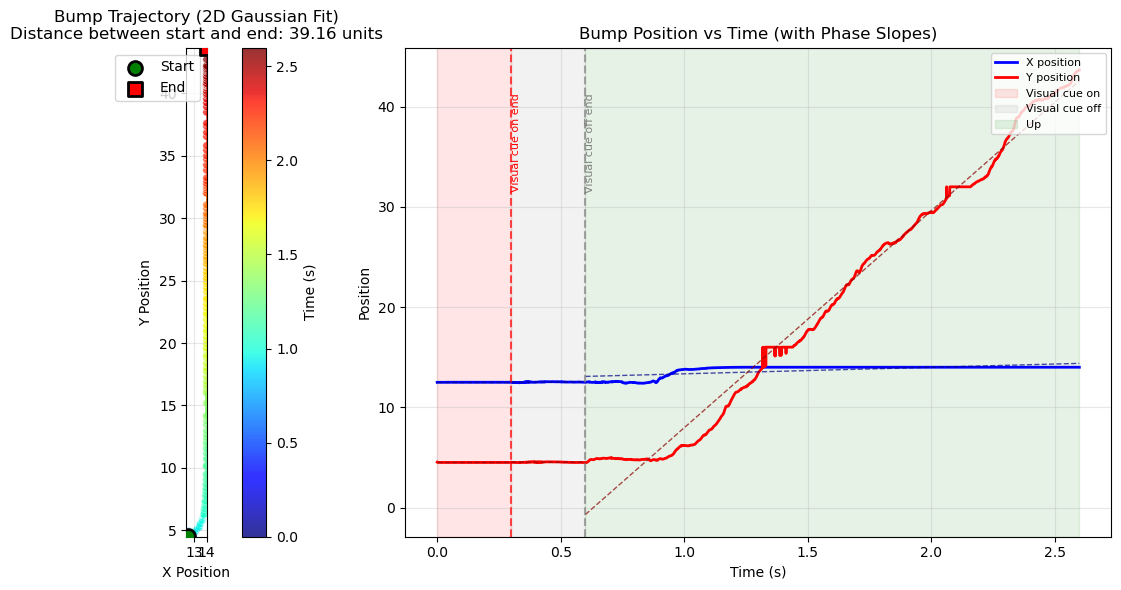


Trajectory Analysis:

Fitting 2D Gaussians:  91%|█████████▏| 2375/2600 [02:43<00:18, 12.35it/s]

Fitting 2D Gaussians:  93%|█████████▎| 2416/2600 [02:43<00:14, 12.65it/s]


Start point: (12.492, 4.528)
End point: (14.000, 43.660)


Fitting 2D Gaussians:  92%|█████████▏| 2382/2600 [02:41<00:14, 14.64it/s]

Total distance between start and end: 39.161 units

Phase-based velocity analysis:
Visual cue on  : vx= 0.010, vy=-0.008, speed= 0.003 rad/s
Visual cue off : vx= 0.110, vy=-0.023, speed= 0.022 rad/s


Fitting 2D Gaussians:  99%|█████████▉| 2568/2600 [02:46<00:02, 12.52it/s]

Up             : vx= 0.651, vy=21.648, speed= 4.252 rad/s

Phase summary:

Fitting 2D Gaussians:  92%|█████████▏| 2385/2600 [02:41<00:17, 12.32it/s]

Fitting 2D Gaussians:  92%|█████████▏| 2388/2600 [02:39<00:17, 12.04it/s]

Fitting 2D Gaussians:  86%|████████▌ | 2229/2600 [02:34<00:26, 13.93it/s]

Fitting 2D Gaussians:  84%|████████▍ | 2191/2600 [02:37<00:25, 15.75it/s]

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s

Fitting 2D Gaussians:  91%|█████████▏| 2377/2600 [02:43<00:17, 12.60it/s]


Visual cue off : 0.3-0.6s (0.3s duration), speed=0.022 rad/s

Fitting 2D Gaussians:  88%|████████▊ | 2294/2600 [02:35<00:21, 14.32it/s]

Fitting 2D Gaussians:  93%|█████████▎| 2418/2600 [02:43<00:12, 14.14it/s]

Up             : 0.6-2.6s (2.0s duration), speed=4.252 rad/s

Fitting 2D Gaussians:  92%|█████████▏| 2384/2600 [02:41<00:15, 14.31it/s]


Distance between start and end: 39.161 units


Fitting 2D Gaussians:  93%|█████████▎| 2430/2600 [02:42<00:13, 12.66it/s]

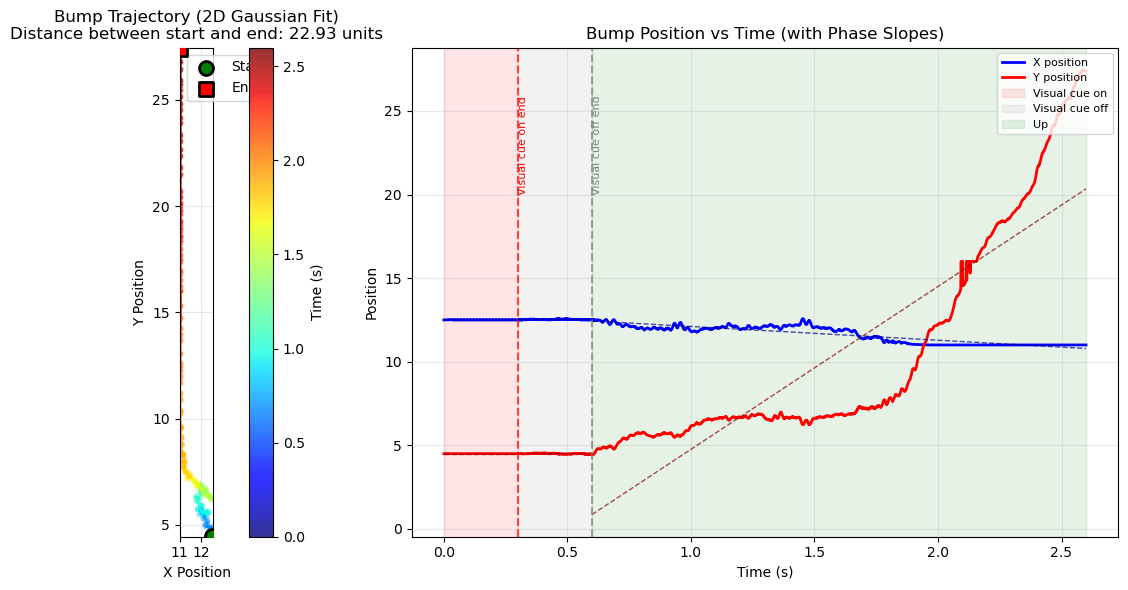

Fitting 2D Gaussians:  86%|████████▌ | 2242/2600 [02:40<00:21, 16.42it/s]


Trajectory Analysis:


Fitting 2D Gaussians:  87%|████████▋ | 2271/2600 [02:38<00:23, 14.24it/s]

Start point: (12.496, 4.496)

Fitting 2D Gaussians:  93%|█████████▎| 2417/2600 [02:46<00:14, 12.43it/s]


End point: (11.000, 27.378)


Fitting 2D Gaussians:  93%|█████████▎| 2426/2600 [02:45<00:11, 15.49it/s]

Total distance between start and end: 22.931 units

Fitting 2D Gaussians:  95%|█████████▌| 2471/2600 [02:46<00:09, 13.50it/s]



Phase-based velocity analysis:

Fitting 2D Gaussians:  90%|████████▉ | 2339/2600 [02:38<00:18, 14.35it/s]

Fitting 2D Gaussians:  94%|█████████▍| 2439/2600 [02:44<00:09, 17.89it/s]

Visual cue on  : vx=-0.012, vy=-0.003, speed= 0.002 rad/s
Visual cue off : vx= 0.015, vy=-0.113, speed= 0.022 rad/s


Fitting 2D Gaussians:  86%|████████▋ | 2244/2600 [02:40<00:22, 15.87it/s]

Up             : vx=-0.823, vy= 9.743, speed= 1.920 rad/s

Phase summary:


Fitting 2D Gaussians:  87%|████████▋ | 2273/2600 [02:38<00:21, 15.39it/s]

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s


Fitting 2D Gaussians:  94%|█████████▎| 2432/2600 [02:43<00:13, 12.39it/s]

Visual cue off : 0.3-0.6s (0.3s duration), speed=0.022 rad/s


Fitting 2D Gaussians:  93%|█████████▎| 2419/2600 [02:46<00:13, 13.23it/s]

Up             : 0.6-2.6s (2.0s duration), speed=1.920 rad/s
Distance between start and end: 22.931 units


Fitting 2D Gaussians:  99%|█████████▉| 2580/2600 [02:53<00:01, 14.80it/s]

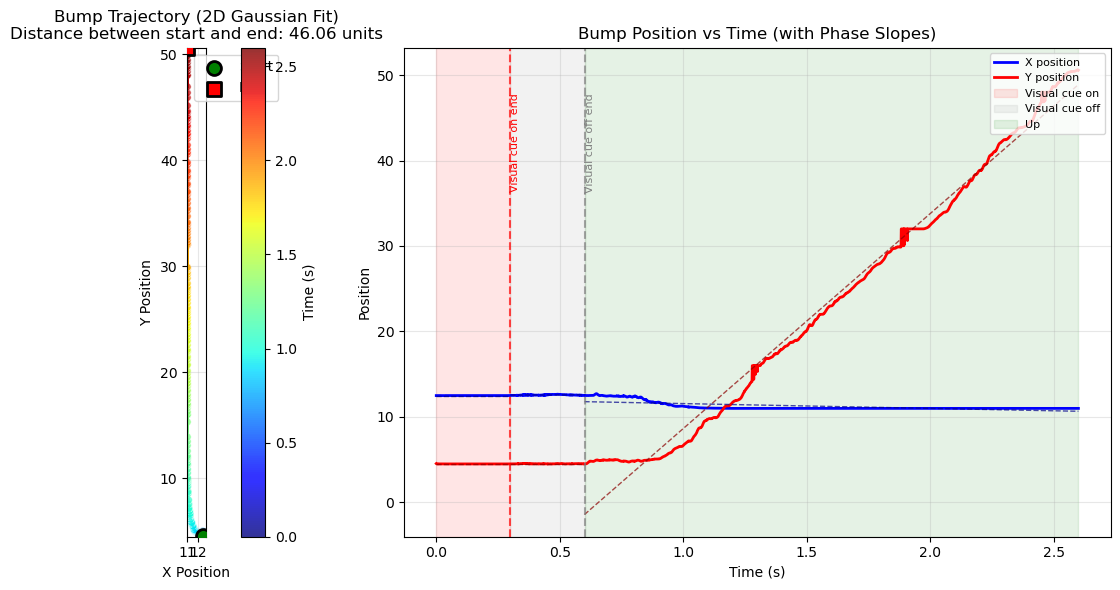


Trajectory Analysis:


Fitting 2D Gaussians:  96%|█████████▌| 2497/2600 [02:47<00:05, 18.12it/s]

Start point: (12.498, 4.538)

Fitting 2D Gaussians: 100%|█████████▉| 2590/2600 [02:51<00:00, 18.10it/s]


End point: (11.000, 50.572)
Total distance between start and end: 46.058 units


Fitting 2D Gaussians:  92%|█████████▏| 2392/2600 [02:49<00:13, 15.25it/s]


Phase-based velocity analysis:

Fitting 2D Gaussians: 100%|█████████▉| 2589/2600 [02:54<00:00, 19.15it/s]

Fitting 2D Gaussians:  99%|█████████▉| 2577/2600 [02:55<00:01, 19.21it/s]

Visual cue on  : vx= 0.006, vy=-0.011, speed= 0.003 rad/s
Visual cue off : vx= 0.132, vy= 0.007, speed= 0.026 rad/s

Fitting 2D Gaussians:  93%|█████████▎| 2425/2600 [02:47<00:11, 15.24it/s]


Up             : vx=-0.562, vy=25.165, speed= 4.942 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.026 rad/s

Fitting 2D Gaussians:  99%|█████████▉| 2582/2600 [02:54<00:01, 14.41it/s]


Up             : 0.6-2.6s (2.0s duration), speed=4.942 rad/s
Distance between start and end: 46.058 units


Fitting 2D Gaussians:  93%|█████████▎| 2423/2600 [02:51<00:09, 18.81it/s]

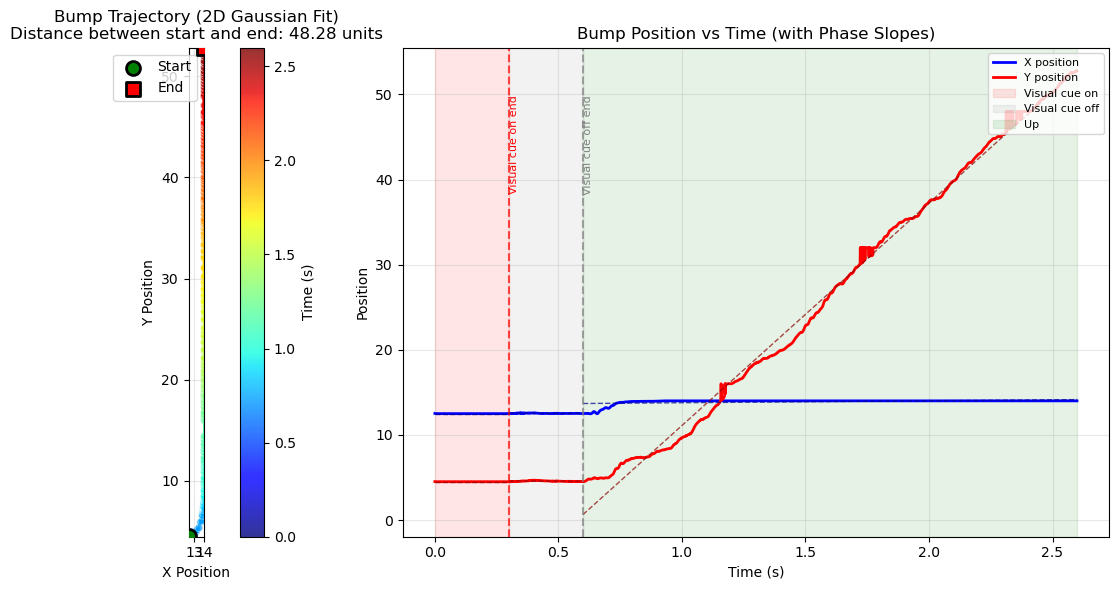

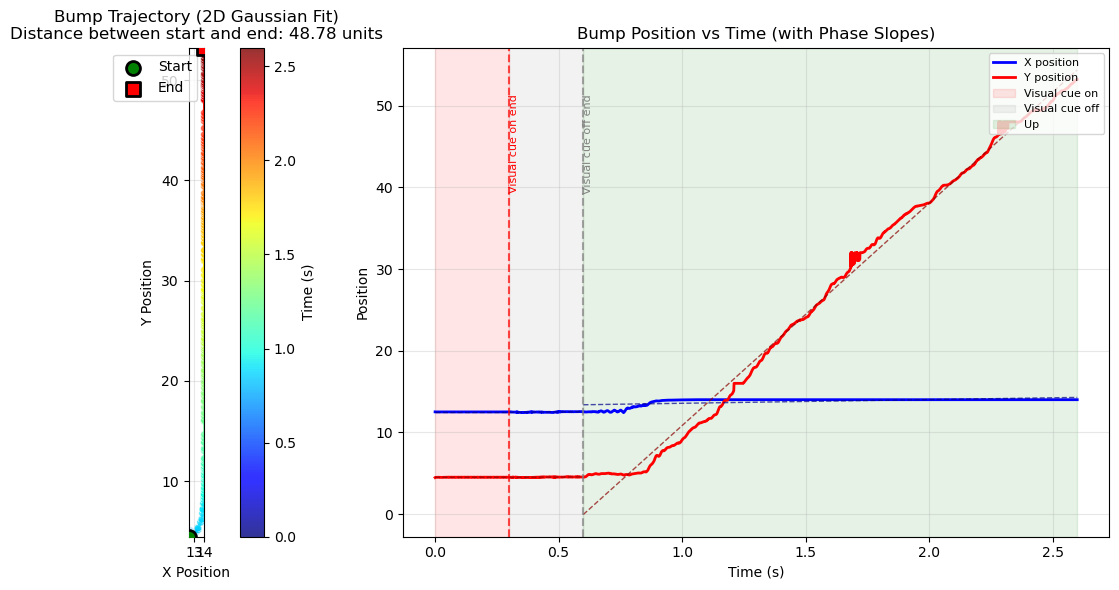


Trajectory Analysis:
Trajectory Analysis:

Fitting 2D Gaussians:  94%|█████████▍| 2452/2600 [02:48<00:09, 16.22it/s]




Start point: (12.522, 4.517)Start point: (12.509, 4.465)

End point: (14.000, 53.223)End point: (14.000, 52.771)

Total distance between start and end: 48.277 unitsTotal distance between start and end: 48.781 units

Phase-based velocity analysis:


Fitting 2D Gaussians:  97%|█████████▋| 2521/2600 [02:49<00:05, 14.30it/s]


Phase-based velocity analysis:


Fitting 2D Gaussians:  93%|█████████▎| 2425/2600 [02:51<00:09, 18.91it/s]


Visual cue on  : vx=-0.002, vy= 0.023, speed= 0.004 rad/s

Visual cue on  : vx=-0.006, vy=-0.008, speed= 0.002 rad/s
Visual cue off : vx=-0.107, vy=-0.121, speed= 0.032 rad/s
Visual cue off : vx= 0.269, vy= 0.236, speed= 0.070 rad/sUp             : vx= 0.230, vy=26.130, speed= 5.131 rad/s

Phase summary:

Fitting 2D Gaussians:  94%|█████████▍| 2455/2600 [02:48<00:07, 19.70it/s]



==================================================Up             : vx= 0.450, vy=27.227, speed= 5.347 rad/s


Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s==================================================

Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.004 rad/sVisual cue off : 0.3-0.6s (0.3s duration), speed=0.032 rad/s

Visual cue off : 0.3-0.6s (0.3s duration), speed=0.070 rad/sUp             : 0.6-2.6s (2.0s duration), speed=5.131 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=5.347 rad/s
Distance between start and end: 48.277 units

Fitting 2D Gaussians:  97%|█████████▋| 2523/2600 [02:49<00:04, 15.44it/s]


Distance between start and end: 48.781 units

Fitting 2D Gaussians:  93%|█████████▎| 2427/2600 [02:51<00:09, 18.79it/s]

Fitting 2D Gaussians:  95%|█████████▍| 2458/2600 [02:49<00:06, 21.77it/s]

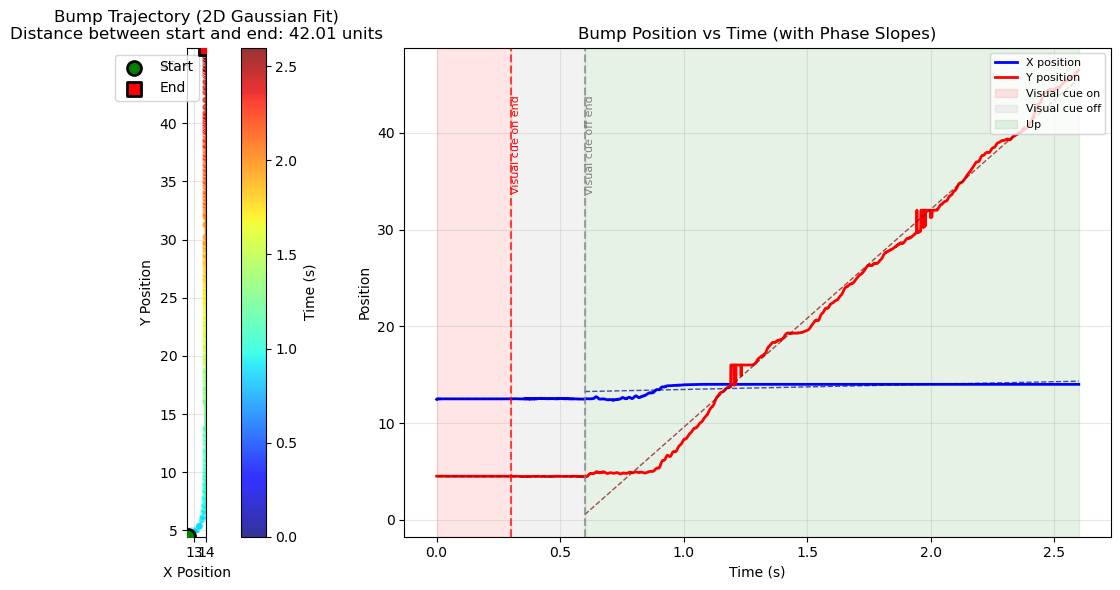


Trajectory Analysis:
Start point: (12.451, 4.513)
End point: (14.000, 46.497)
Total distance between start and end: 42.013 units


Fitting 2D Gaussians:  93%|█████████▎| 2430/2600 [02:51<00:08, 19.72it/s]


Phase-based velocity analysis:

Fitting 2D Gaussians:  95%|█████████▍| 2463/2600 [02:49<00:04, 29.09it/s]

Fitting 2D Gaussians:  97%|█████████▋| 2526/2600 [02:49<00:04, 16.98it/s]

Visual cue on  : vx= 0.013, vy=-0.010, speed= 0.003 rad/s
Visual cue off : vx=-0.018, vy=-0.000, speed= 0.004 rad/s
Up             : vx= 0.536, vy=22.539, speed= 4.427 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s

Fitting 2D Gaussians:  97%|█████████▋| 2529/2600 [02:49<00:03, 19.72it/s]

Fitting 2D Gaussians:  95%|█████████▍| 2467/2600 [02:49<00:04, 30.54it/s]

Visual cue off : 0.3-0.6s (0.3s duration), speed=0.004 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=4.427 rad/s

Fitting 2D Gaussians:  94%|█████████▎| 2434/2600 [02:51<00:07, 23.01it/s]


Distance between start and end: 42.013 units


Fitting 2D Gaussians:  94%|█████████▍| 2438/2600 [02:52<00:06, 26.77it/s]

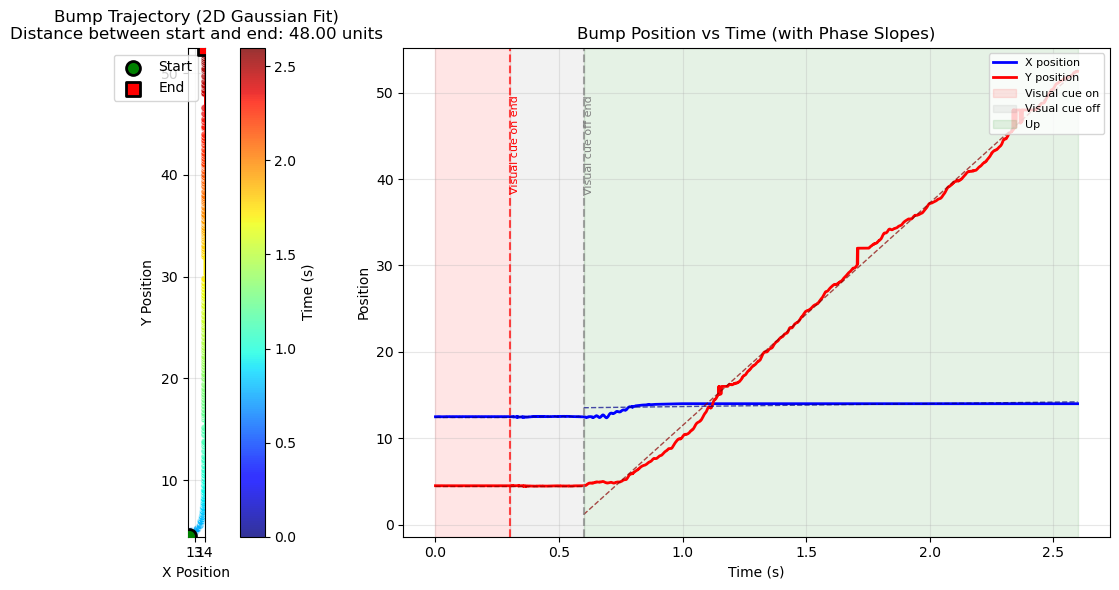


Trajectory Analysis:
Start point: (12.489, 4.506)
End point: (14.000, 52.484)
Total distance between start and end: 48.002 units

Phase-based velocity analysis:
Visual cue on  : vx= 0.011, vy=-0.008, speed= 0.003 rad/s
Visual cue off : vx= 0.141, vy=-0.008, speed= 0.028 rad/s
Up             : vx= 0.341, vy=25.742, speed= 5.055 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.003 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.028 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=5.055 rad/s
Distance between start and end: 48.002 units


Fitting 2D Gaussians:  98%|█████████▊| 2540/2600 [02:53<00:01, 46.90it/s]

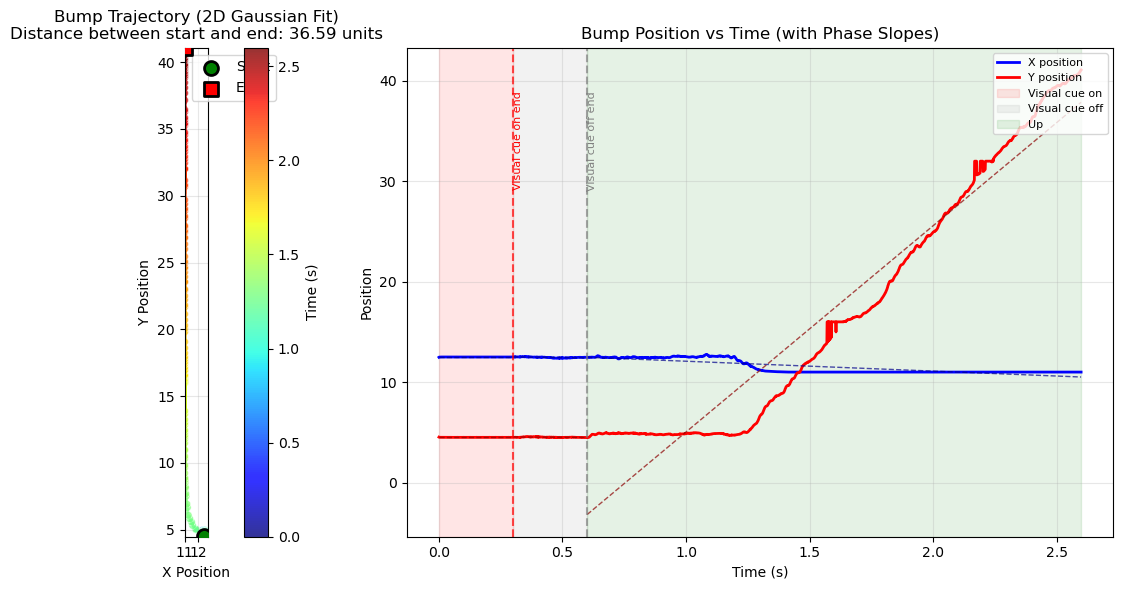


Trajectory Analysis:
Start point: (12.474, 4.521)
End point: (11.000, 41.083)
Total distance between start and end: 36.592 units

Phase-based velocity analysis:
Visual cue on  : vx= 0.005, vy=-0.009, speed= 0.002 rad/s
Visual cue off : vx=-0.328, vy=-0.162, speed= 0.072 rad/s
Up             : vx=-0.983, vy=20.535, speed= 4.037 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s

Fitting 2D Gaussians:  99%|█████████▉| 2571/2600 [02:51<00:00, 52.94it/s]


Visual cue off : 0.3-0.6s (0.3s duration), speed=0.072 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=4.037 rad/s


Fitting 2D Gaussians:  98%|█████████▊| 2546/2600 [02:54<00:01, 49.78it/s]

Distance between start and end: 36.592 units


Fitting 2D Gaussians: 100%|█████████▉| 2588/2600 [02:54<00:00, 65.89it/s]

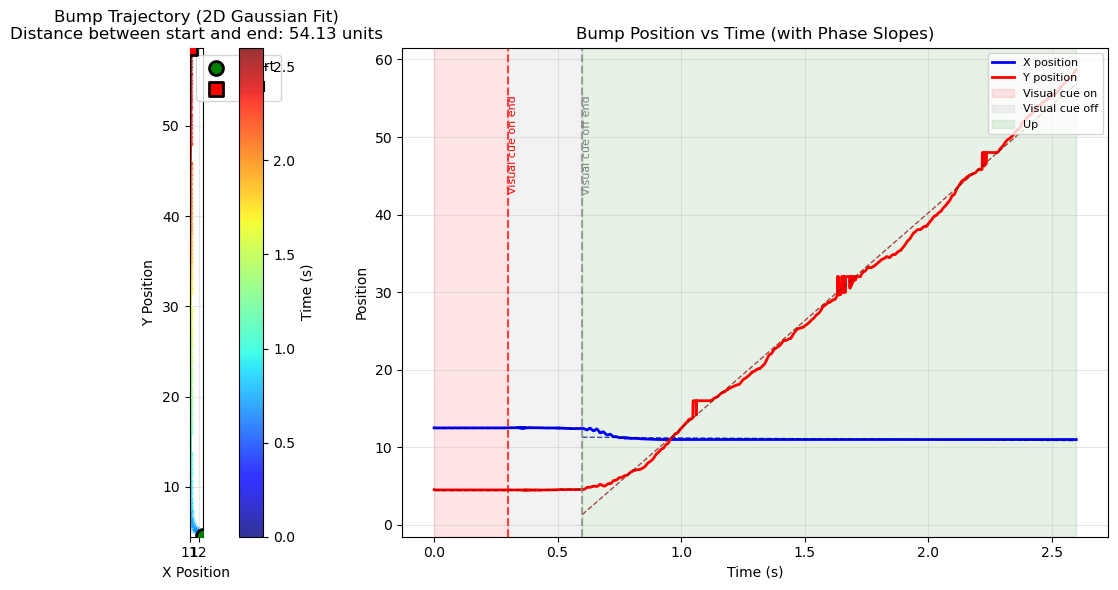


Trajectory Analysis:
Start point: (12.512, 4.532)
End point: (11.000, 58.646)
Total distance between start and end: 54.135 units

Phase-based velocity analysis:
Visual cue on  : vx=-0.000, vy=-0.009, speed= 0.002 rad/s
Visual cue off : vx=-0.373, vy= 0.281, speed= 0.092 rad/s
Up             : vx=-0.219, vy=27.773, speed= 5.453 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.092 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=5.453 rad/s
Distance between start and end: 54.135 units


Fitting 2D Gaussians: 100%|██████████| 2600/2600 [02:54<00:00, 14.87it/s]


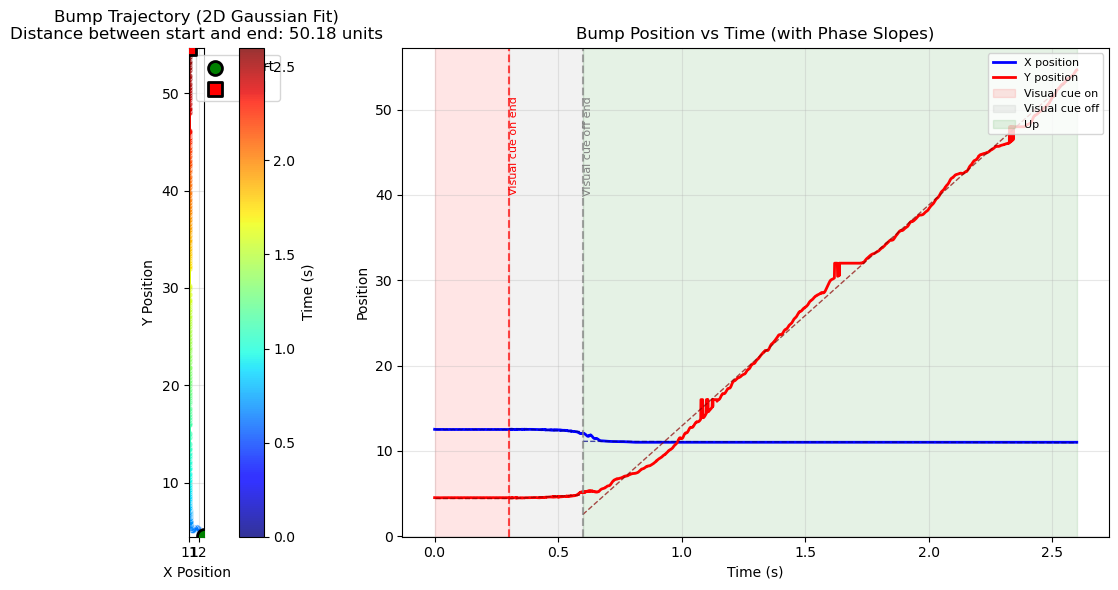


Trajectory Analysis:
Start point: (12.516, 4.505)
End point: (11.000, 54.659)
Total distance between start and end: 50.177 units

Phase-based velocity analysis:
Visual cue on  : vx=-0.009, vy= 0.006, speed= 0.002 rad/s
Visual cue off : vx=-1.197, vy= 1.462, speed= 0.371 rad/s
Up             : vx=-0.082, vy=25.922, speed= 5.090 rad/s

Phase summary:
Visual cue on  : 0.0-0.3s (0.3s duration), speed=0.002 rad/s
Visual cue off : 0.3-0.6s (0.3s duration), speed=0.371 rad/s
Up             : 0.6-2.6s (2.0s duration), speed=5.090 rad/s
Distance between start and end: 50.177 units


Running simulations: 100%|██████████| 10/10 [07:11<00:00, 43.19s/it]


In [21]:
from tqdm import tqdm, trange
from multiprocessing import Pool
import multiprocessing as mp
import random

parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, # 0.143
  "w_IE": 0.76, # 0.74
  "w_II": 0.01, # 0.01
  "w_PP": 0.01,
  "w_EP": 0.013, # 0.012
  "w_PE": 0.71, # .709
  "sigma": 0.001,
}

events = [
        {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
        {'type': 'visual_cue_off', 'duration': 300*ms},
        {'type': 'shift', 'direction': 'up', 'strength': 0.018, 'duration': 2000*ms},
    ]


def run_single_simulation(seed):
    """
    Run a single simulation with a given random seed
    
    Args:
        seed (int): Random seed for the simulation
    
    Returns:
        tuple: (speed, bump_positions) from the simulation
    """
    t, fr, fr_penx, fr_peny = simulator(w_EE = parameters['w_EE'], # EB <-> EB
                    w_EI = parameters['w_EI'], # EPG -> R # 0.15
                    w_IE = parameters['w_IE'], # R -> EPG
                    w_II = parameters['w_II'], # R <-> R
                    w_PP = parameters['w_PP'], # PEN <-> PEN
                    w_EP = parameters['w_EP'], # EB -> PEN 
                    w_PE = parameters['w_PE'], # PEN -> EB
                    sigma = parameters['sigma'], # noise level
                    
                    events = events,
                    defaultclock_dt=0.1,
                    seed=seed)

    processed_data = process_data(fr)
    bp, fit_params = bump_position(processed_data)
    trajectory_results = analyze_trajectory(bp, fit_params, processed_data, events)
    direction = events[2]['direction'].capitalize() 
    speed = trajectory_results['phase_results'][direction]['speed']
    bump_pos = trajectory_results['bump_positions']
    return speed, bump_pos


def run_multiple_simulations(parameters, events, num_simulations=10, n_processes=None):
    """
    Run multiple simulations with different random seeds and collect results using parallel computation
    
    Args:
        parameters (dict): Parameters for the simulation
        events (list): List of events for the simulation
        num_simulations (int): Number of simulations to run
        n_processes (int): Number of processes to use. If None, uses all available CPUs
    
    Returns:
        tuple: (speeds, bump_positions) lists from all simulations
    """ 
    if n_processes is None:
        n_processes = mp.cpu_count()
    
    print(f"Running {num_simulations} simulations using {n_processes} processes")
    
    # Create list of seeds for each simulation
    seeds = list(range(num_simulations))
    
    # Run simulations in parallel
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.imap(run_single_simulation, seeds),
            total=num_simulations,
            desc="Running simulations"
        ))
    
    # Separate speeds and bump_positions
    speeds = [result[0] for result in results]
    bump_positions = [result[1] for result in results]
    
    return speeds, bump_positions

speeds, bump_positions = run_multiple_simulations(parameters, events, num_simulations=10, n_processes=10)

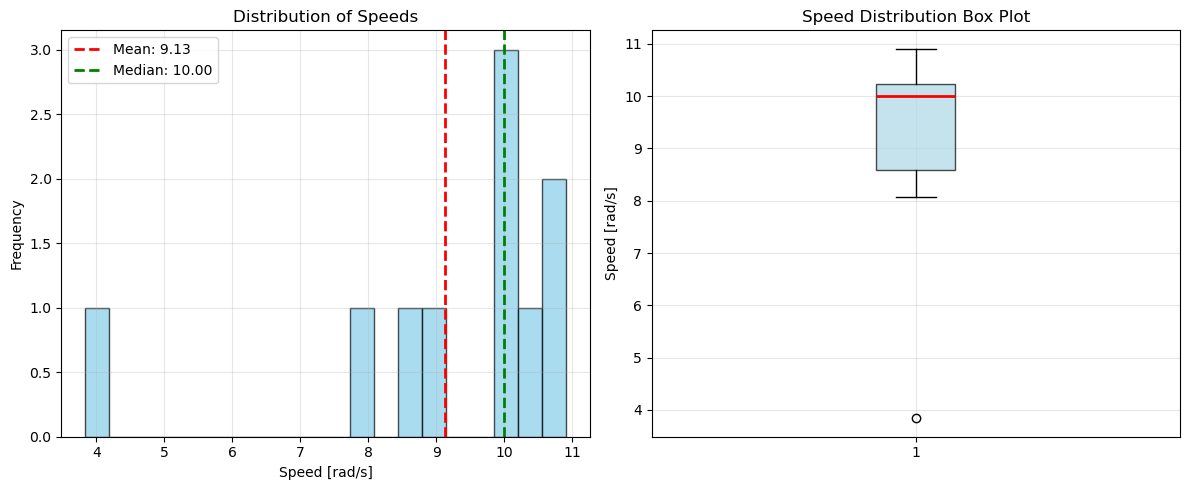

Speed Statistics:
Mean: 9.13 [rad/s]
Standard Deviation: 1.98 [rad/s]
Median: 10.00 [rad/s]
Min: 3.84 [rad/s]
Max: 10.91 [rad/s]



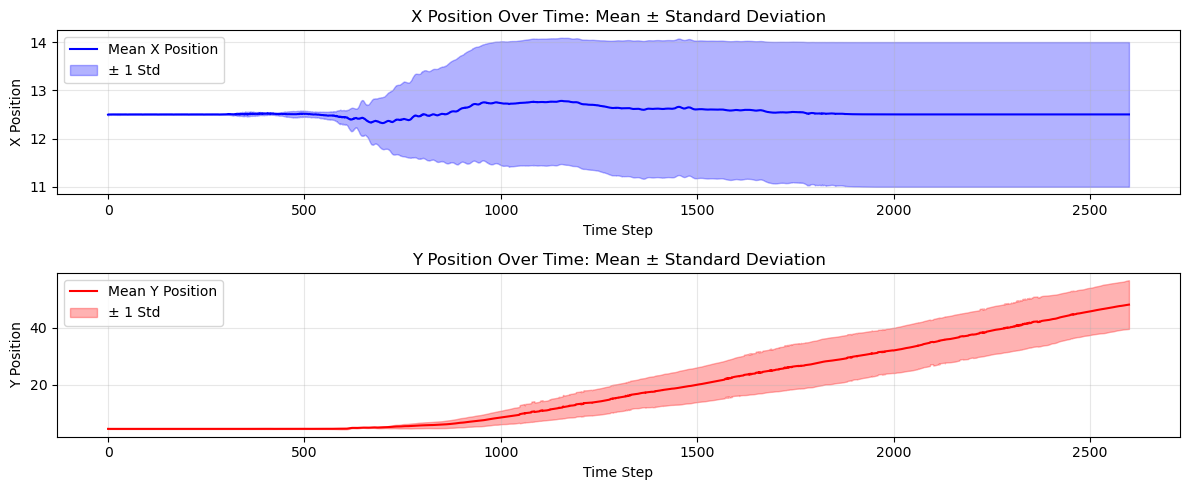

In [22]:
# Calculate statistics for speeds
speeds_array = np.array(speeds)
speed_mean = np.mean(speeds_array)
speed_std = np.std(speeds_array)
speed_median = np.median(speeds_array)
speed_min = np.min(speeds_array)
speed_max = np.max(speeds_array)

# Plot speed statistics
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of speeds
ax1.hist(speeds_array * 2 * np.pi / 16, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(speed_mean * 2 * np.pi / 16, color='red', linestyle='--', linewidth=2, label=f'Mean: {speed_mean*2*np.pi/16:.2f}')
ax1.axvline(speed_median * 2 * np.pi / 16, color='green', linestyle='--', linewidth=2, label=f'Median: {speed_median*2*np.pi/16:.2f}')
ax1.set_xlabel('Speed [rad/s]')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Speeds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot of speeds
ax2.boxplot(speeds_array * 2 * np.pi / 16, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Speed [rad/s]')
ax2.set_title('Speed Distribution Box Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Speed Statistics:")
print(f"Mean: {speed_mean*2*np.pi/16:.2f} [rad/s]")
print(f"Standard Deviation: {speed_std*2*np.pi/16:.2f} [rad/s]")
print(f"Median: {speed_median*2*np.pi/16:.2f} [rad/s]")
print(f"Min: {speed_min*2*np.pi/16:.2f} [rad/s]")
print(f"Max: {speed_max*2*np.pi/16:.2f} [rad/s]")
print()

pos_mean = np.mean(bump_positions, axis=0)
pos_std = np.std(bump_positions, axis=0)
pos_median = np.median(bump_positions, axis=0)
pos_min = np.min(bump_positions, axis=0)
pos_max = np.max(bump_positions, axis=0)
# print(pos_mean.shape)

import matplotlib.pyplot as plt

# Since pos_mean has shape (2600, 2), we need to handle the 2D position data
# Let's plot the trajectory of mean positions over time
time_steps = np.arange(pos_mean.shape[0])

# Create subplots for x and y positions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))

# Plot x-position over time
ax1.plot(time_steps, pos_mean[:, 0], 'b-', label='Mean X Position')
ax1.fill_between(time_steps, 
                 pos_mean[:, 0] - pos_std[:, 0], 
                 pos_mean[:, 0] + pos_std[:, 0], 
                 alpha=0.3, color='blue', label='± 1 Std')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('X Position')
ax1.set_title('X Position Over Time: Mean ± Standard Deviation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot y-position over time
ax2.plot(time_steps, pos_mean[:, 1], 'r-', label='Mean Y Position')
ax2.fill_between(time_steps, 
                 pos_mean[:, 1] - pos_std[:, 1], 
                 pos_mean[:, 1] + pos_std[:, 1], 
                 alpha=0.3, color='red', label='± 1 Std')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Y Position')
ax2.set_title('Y Position Over Time: Mean ± Standard Deviation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




vary shifter strenght

In [ ]:
from tqdm import tqdm, trange
from multiprocessing import Pool
import multiprocessing as mp
import random

parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, # 0.143
  "w_IE": 0.76, # 0.74
  "w_II": 0.01, # 0.01
  "w_PP": 0.01,
  "w_EP": 0.013, # 0.012
  "w_PE": 0.71, # .709
  "sigma": 0.001,
}

events = [
        {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
        {'type': 'visual_cue_off', 'duration': 300*ms},
        {'type': 'shift', 'direction': 'down', 'strength': 0.018, 'duration': 2000*ms},
    ]


def run_single_simulation(seed, shift_strength):
    """
    Run a single simulation with a given random seed
    
    Args:
        seed (int): Random seed for the simulation
    
    Returns:
        tuple: (speed, bump_positions) from the simulation
    """
    events[2]['strength'] = shift_strength
    t, fr, fr_penx, fr_peny = simulator(w_EE = parameters['w_EE'], # EB <-> EB
                    w_EI = parameters['w_EI'], # EPG -> R # 0.15
                    w_IE = parameters['w_IE'], # R -> EPG
                    w_II = parameters['w_II'], # R <-> R
                    w_PP = parameters['w_PP'], # PEN <-> PEN
                    w_EP = parameters['w_EP'], # EB -> PEN 
                    w_PE = parameters['w_PE'], # PEN -> EB
                    sigma = parameters['sigma'], # noise level
                    
                    events = events,
                    defaultclock_dt=0.1,
                    seed=seed)

    processed_data = process_data(fr)
    bp, fit_params = bump_position(processed_data)
    trajectory_results = analyze_trajectory(bp, fit_params, processed_data, events)
    direction = events[2]['direction'].capitalize() 
    speed = trajectory_results['phase_results'][direction]['speed']
    bump_pos = trajectory_results['bump_positions']
    return speed, bump_pos


def run_multiple_simulations(parameters, events, num_simulations=10, n_processes=None):
    """
    Run multiple simulations with different random seeds and collect results using parallel computation
    
    Args:
        parameters (dict): Parameters for the simulation
        events (list): List of events for the simulation
        num_simulations (int): Number of simulations to run
        n_processes (int): Number of processes to use. If None, uses all available CPUs
    
    Returns:
        tuple: (speeds, bump_positions) lists from all simulations
    """ 
    if n_processes is None:
        n_processes = mp.cpu_count()
    
    print(f"Running {num_simulations} simulations using {n_processes} processes")
    
    # Create list of seeds for each simulation
    seeds = list(range(num_simulations))
    shift_strengths = np.linspace(0.01, 0.02, num_simulations)
    
    # Run simulations in parallel
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(
            pool.starmap(run_single_simulation, zip(seeds, shift_strengths)),
            total=num_simulations,
            desc="Running simulations"
        ))
    # Separate speeds and bump_positions
    speeds = [result[0] for result in results]
    bump_positions = [result[1] for result in results]
    
    return speeds, bump_positions

speeds, bump_positions = run_multiple_simulations(parameters, events, num_simulations=50, n_processes=25)

Running 50 simulations using 25 processes
06:23:23 : 0 min 2.0 sec -> simulation start
06:23:23 : 0 min 2.0 sec -> simulation start
06:23:23 : 0 min 2.1 sec -> simulation start
06:23:23 : 0 min 2.2 sec -> simulation start
06:23:24 : 0 min 2.3 sec -> simulation start
06:23:24 : 0 min 2.4 sec -> simulation start
06:23:24 : 0 min 2.5 sec -> simulation start
06:23:24 : 0 min 2.5 sec -> simulation start
06:23:24 : 0 min 2.6 sec -> simulation start
06:23:24 : 0 min 2.6 sec -> simulation start
06:23:24 : 0 min 2.6 sec -> simulation start
06:23:24 : 0 min 2.7 sec -> simulation start
06:23:24 : 0 min 2.7 sec -> simulation start
06:23:24 : 0 min 2.7 sec -> simulation start
06:23:24 : 0 min 2.8 sec -> simulation start
06:23:24 : 0 min 2.9 sec -> simulation start
06:23:24 : 0 min 3.0 sec -> simulation start
06:23:24 : 0 min 3.0 sec -> simulation start
06:23:24 : 0 min 3.1 sec -> simulation start
06:23:24 : 0 min 3.1 sec -> simulation start
06:23:24 : 0 min 3.1 sec -> simulation start
06:23:24 : 0 

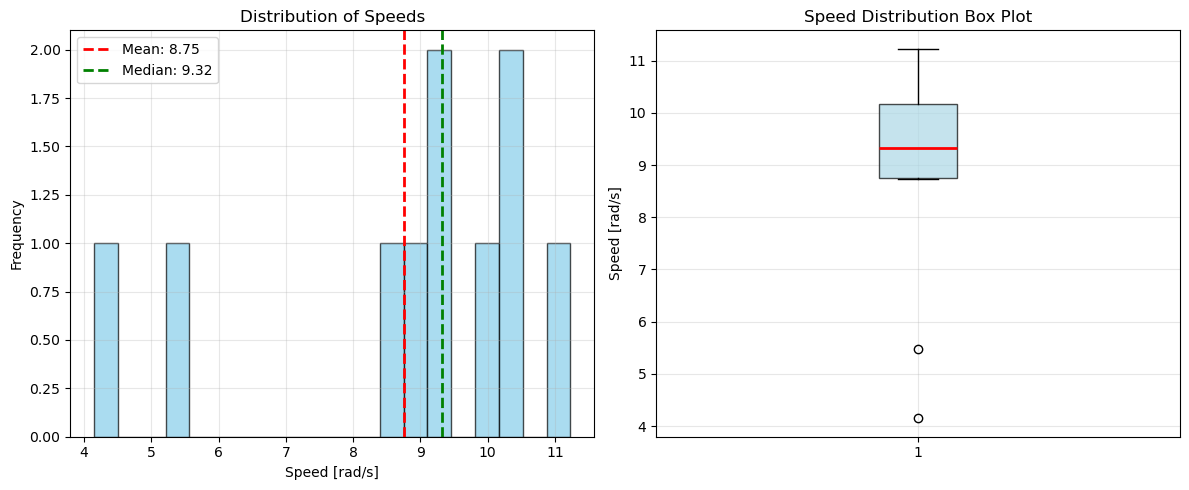

Speed Statistics:
Mean: 8.75 [rad/s]
Standard Deviation: 2.12 [rad/s]
Median: 9.32 [rad/s]
Min: 4.15 [rad/s]
Max: 11.23 [rad/s]



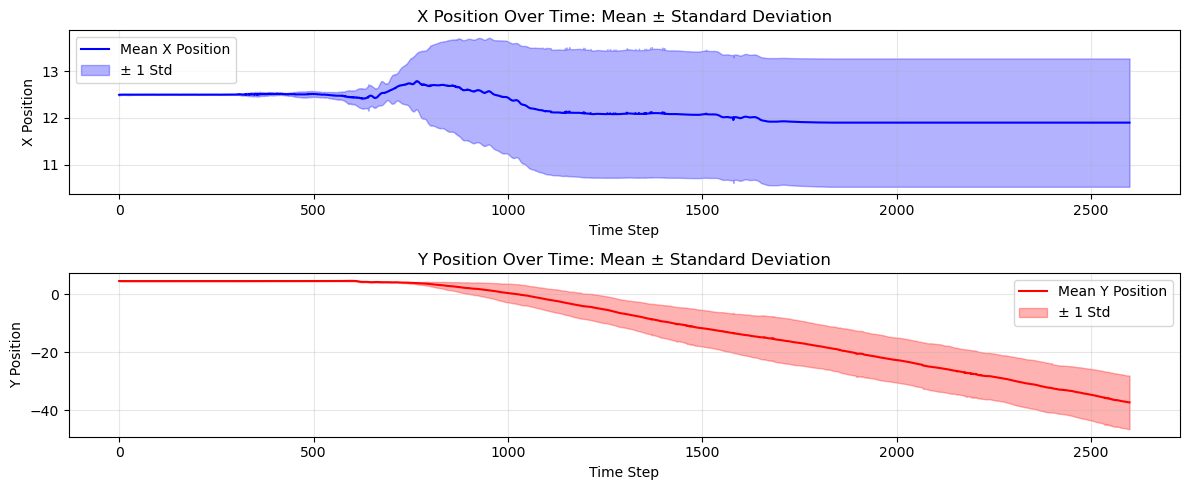

In [ ]:
# # Calculate statistics for speeds
# speeds_array = np.array(speeds)
# speed_mean = np.mean(speeds_array)
# speed_std = np.std(speeds_array)
# speed_median = np.median(speeds_array)
# speed_min = np.min(speeds_array)
# speed_max = np.max(speeds_array)

# Plot speed statistics
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of speeds
ax1.hist(speeds_array * 2 * np.pi / 16, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(speed_mean * 2 * np.pi / 16, color='red', linestyle='--', linewidth=2, label=f'Mean: {speed_mean*2*np.pi/16:.2f}')
ax1.axvline(speed_median * 2 * np.pi / 16, color='green', linestyle='--', linewidth=2, label=f'Median: {speed_median*2*np.pi/16:.2f}')
ax1.set_xlabel('Speed [rad/s]')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Speeds')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot of speeds
ax2.boxplot(speeds_array * 2 * np.pi / 16, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7),
            medianprops=dict(color='red', linewidth=2))
ax2.set_ylabel('Speed [rad/s]')
ax2.set_title('Speed Distribution Box Plot')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Speed Statistics:")
print(f"Mean: {speed_mean*2*np.pi/16:.2f} [rad/s]")
print(f"Standard Deviation: {speed_std*2*np.pi/16:.2f} [rad/s]")
print(f"Median: {speed_median*2*np.pi/16:.2f} [rad/s]")
print(f"Min: {speed_min*2*np.pi/16:.2f} [rad/s]")
print(f"Max: {speed_max*2*np.pi/16:.2f} [rad/s]")
print()

pos_mean = np.mean(bump_positions, axis=0)
pos_std = np.std(bump_positions, axis=0)
pos_median = np.median(bump_positions, axis=0)
pos_min = np.min(bump_positions, axis=0)
pos_max = np.max(bump_positions, axis=0)
# print(pos_mean.shape)

import matplotlib.pyplot as plt

# Since pos_mean has shape (2600, 2), we need to handle the 2D position data
# Let's plot the trajectory of mean positions over time
time_steps = np.arange(pos_mean.shape[0])

# Create subplots for x and y positions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5))

# Plot x-position over time
ax1.plot(time_steps, pos_mean[:, 0], 'b-', label='Mean X Position')
ax1.fill_between(time_steps, 
                 pos_mean[:, 0] - pos_std[:, 0], 
                 pos_mean[:, 0] + pos_std[:, 0], 
                 alpha=0.3, color='blue', label='± 1 Std')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('X Position')
ax1.set_title('X Position Over Time: Mean ± Standard Deviation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot y-position over time
ax2.plot(time_steps, pos_mean[:, 1], 'r-', label='Mean Y Position')
ax2.fill_between(time_steps, 
                 pos_mean[:, 1] - pos_std[:, 1], 
                 pos_mean[:, 1] + pos_std[:, 1], 
                 alpha=0.3, color='red', label='± 1 Std')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Y Position')
ax2.set_title('Y Position Over Time: Mean ± Standard Deviation')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


